# **Bank Marketing Campaign - Term Deposit Analysis and Prediction**

**Purwadhika Job Connector Data Science (JCDSJKTPM-34) Final Project**

Author: Yonathan Hary Hutagalung, Fatimah Azzahra, Tengku Arika Hazera (Team Alpha)

Date: 19 February 2026

## Import Library

In [ ]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 8.8 MB/s eta 0:00:00


In [ ]:
# Basic library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical library
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu

# ML library
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer, fbeta_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# Metrics library
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, roc_curve,
                            precision_recall_curve, auc, make_scorer, fbeta_score)

# Model interpretation
import shap

# Model saving
import joblib

In [ ]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Load Dataset

In [ ]:
df = pd.read_csv('raw_data.csv', sep=';', na_values='unknown')
df.head()

In [ ]:
df_processed = df.copy()

## **1. Introduction**

### **1.1 Context**

This project analyzes [marketing campaign data related to term deposits](https://www.kaggle.com/code/volodymyrgavrysh/bank-marketing-campaigns-dataset-analysis) offered by a Portuguese bank to its customers. The campaigns were conducted primarily through direct phone calls, offering customers the opportunity to subscribe a term deposit. The data were collected from [May 2008 to November 2010](https://archive.ics.uci.edu/dataset/222/bank+marketing). The dataset contains information about:

- Bank customer demographics and financial status
- Campaign contact details
- Previous campaign outcomes
- Social and economic context indicators

The objective is to predict whether a customer will subscribe to a term deposit based on these features.

In 2008, a global financial crisis originated in the United States, which disrupted banking systems worldwide, including Portuguese banks. Using the available banking data, this project also analyzes the impact of the financial pre-crisis, during crisis and the post-crisis recovery period on customers' term-deposit subscription behavior.

### **1.2 Business Problem**

Banks invest significant resources in marketing campaigns for term deposits. However, not all customers are equally likely to subscribe. A mass marketing approach without proper targeting may result in:

1. Wasted resources on customers unlikely to subscribe
2. Inefficient allocation of call center time
3. Potential customer fatigue from excessive contact attempts
4. Suboptimal return on investment (ROI) from marketing campaigns

In addition, the data collection period (2008-2010) coincides with the global financial crisis and the economic recovery phase in Portugal. Macroeconomic conditions such as declining interest rates (Euribor), rising unemployment, and decreasing consumer confidence may influence customers' behavior when making financial decisions, including subscribing to term deposits.

As a result, campaign success is influenced not only by individual customer characteristics but also by the prevailing economic conditions at the time of the campaign. Marketing strategies that are effective during normal periods may not be optimal during crisis or recovery phases.

Therefore, the bank needs to understand:
which customers are the most promising targets and how changes in economic conditions affect the probability of term-deposit subscriptions, so that marketing strategies can be dynamically adjusted according to each economic phase to maximize campaign effectiveness and efficiency.

`Key Questions`:

- Which customers are most likely to subscribe to term deposits?
- What factors most influence a customer's decision?
- How do the financial pre-crisis, during crisis and the recovery period affect term-deposit subscription rates?
- How can we optimize targeting strategies while improving the efficiency of the bank's resource allocation?

### **1.3 Objectives**

`Primary objective`: Analyze customers' data features and build a predictive model to identify customers most likely to subscribe to term deposits, enabling the bank to:

- Optimize marketing campaign efficiency
- Reduce operational costs
- Improve customer experience by reducing unnecessary contacts
- Increase overall campaign success rate

`Success metrics`:

- Maximize Recall (minimize missed potential subscribers)
- Maintain acceptable Precision (avoid too many false positives)
- Optimize F2-Score (prioritize recall over precision)
- Achieve strong PR-AUC score for imbalanced data

### **1.4 Analytical Approach**

This project is a **supervised classification** problem, which give informations on:

- Target variable: Has the customer subscribed to a term deposit? (yes/no)
- Approach: Classification algorithms
- Challenge: Class imbalance (fewer subscriptions than non-subscriptions)

**Methodology:**

`Data Analysis`
1. Exploratory Data Analysis (EDA) with inferential statistics
2. Temporal trend analysis to understand changes in customer behavior during the pre-crisis, during crisis and recovery periods

`Machine Learning`

3. Feature Engineering and preprocessing pipelines
4. Model benchmarking across multiple algorithms
5. Handling class imbalance using resampling techniques
6. Hyperparameter tuning to optimize the best-performing model
7. Model evaluation using business-relevant metrics
8. Cost-benefit–based evaluation to measure the financial impact of model decisions
7. Model interpretation for actionable insights

### **1.5 Stakeholders**

`Primary stakeholders`:

1. Marketing Team: Use predictions to prioritize customer contacts
2. Call Center Operations: Optimize resource allocation
3. Bank Management: Strategic decision-making on campaign investments
4. Finance Team: Manages liquidity planning and funding risk based on projected deposit acquisition, especially during crisis and recovery periods

`Secondary stakeholders`:

5. Data Science Team: Model development and maintenance
6. Business Strategy/Product Team: Develops product offerings and customer segmentation strategies based on analytical insights
7. Customers: Benefit from an improved experience through more targeted and relevant communication

### **1.6 Metrics Selection**

The confusion matrix in this case is defined as follows:
- True Positive (TP): Customers predicted to subscribe who actually subscribe
- False Positive (FP): Customers predicted to subscribe but who do not subscribe → resulting in unnecessary operational costs
- False Negative (FN): Customers predicted not to subscribe but who actually subscribe → resulting in lost revenue opportunities
- True Negative (TN): Customers predicted not to subscribe and who indeed do not subscribe

Considering the business context, False Negative errors have a greater financial impact than False Positive errors. Therefore, the model evaluation strategy focuses on maximizing the ability to capture as many potential customers as possible.

`Primary Metrics`:

**RECALL** (Sensitivity)

- Maximizes the number of potential customers successfully identified
- Reduces revenue loss caused by missed subscribers

 **F2-SCORE**

- Weighted harmonic mean favoring Recall over Precision, since False Negatives are more costly than False Positives
- Balances the need to catch subscribers while maintaining some precision

`Validation Metrics`: **PR-AUC** (Precision-Recall Area Under Curve)
- Better than ROC-AUC for imbalanced datasets
- Focuses on the minority class (subscribers)

`Cost Benefit Analysis`:

- Cost of contact for potential missed customer: Low, 1.648 EUR (Max pain; if cellular)
- Cost of missed subscriber: High (lost deposit revenue: 46.126 EUR)
- Therefore, we accept higher False Positive rate to minimize False Negative
- Cost-benefit simulations are conducted to measure the financial impact of the model's decisions. **We concluded that on our conservative calculation, our wasted call `False Positive` cost us 1.648 EUR on worse-case scenario when the missed opportunity `False negative` will put our revenue at risk of 46.126 EUR. Hence, the ratio of missing one customer is as bad as making annoying 28 calls**

## **2. Comprehensive Exploratory Data Analysis**

### **2.1 Dataset Info and Data Dictionary**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             40858 non-null  object 
 2   marital         41108 non-null  object 
 3   education       39457 non-null  object 
 4   default         32591 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

The dataset has 41,188 row data and 21 columns.

**Descriptive data**

In [ ]:
df.describe()

age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std        1.570960        0.578840       4.628198      1.734447     72.251528  
min       -3.400000       92.201000     -50.800000      0.634000   4963.600000  
25%       -1.800000       93.075000     -42.700000      1.344000   5099.100000  
50%        1.100000       93.749000     -41.800000      4.857000   5191.000000  
75%        1.400000       93.994000     -36.400000      4.961000   5228.100000  
max        1.400000       94.767000     -26.900000      5.045000   5228.100000

In [ ]:
df.describe(include='object')

job  marital          education default housing   loan   contact  \
count    40858    41108              39457   32591   40198  40198     41188   
unique      11        3                  7       2       2      2         2   
top     admin.  married  university.degree      no     yes     no  cellular   
freq     10422    24928              12168   32588   21576  33950     26144   

        month day_of_week     poutcome      y  
count   41188       41188        41188  41188  
unique     10           5            3      2  
top       may         thu  nonexistent     no  
freq    13769        8623        35563  36548

In [ ]:
df_unique = []

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

for i in df.columns:
    unique_count = df[i].nunique()
    unique_values = df[i].unique()
    data_type = df[i].dtype
    df_unique.append({
        "Column Name": i,
        "Number of Unique": unique_count,
        "Data Type": data_type,
        "Unique Sample": unique_values
    })

df_unique = pd.DataFrame(df_unique)
display(df_unique)

Column Name  Number of Unique Data Type  \
0              age                78     int64   
1              job                11    object   
2          marital                 3    object   
3        education                 7    object   
4          default                 2    object   
5          housing                 2    object   
6             loan                 2    object   
7          contact                 2    object   
8            month                10    object   
9      day_of_week                 5    object   
10        duration              1544     int64   
11        campaign                42     int64   
12           pdays                27     int64   
13        previous                 8     int64   
14        poutcome                 3    object   
15    emp.var.rate                10   float64   
16  cons.price.idx                26   float64   
17   cons.conf.idx                26   float64   
18       euribor3m               316   float64   
19     nr.employed                11   float64   
20               y                 2    object   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Unique Sample  
0                                                                                                                                                                                                                                                                                                                                                                                           [56, 57, 37, 40, 45, 59, 41, 24, 25, 29, 35, 54, 46, 50, 39, 30, 55, 49, 34, 52, 58, 32, 38, 44, 42, 60, 53, 47, 51, 48, 33, 31, 43, 36, 28, 27, 26, 22, 23, 20, 21, 61, 19, 18, 70, 66, 76, 67, 73, 88, 95, 77, 68, 75, 63, 80, 62, 65, 72, 82, 64, 71, 69, 78, 85, 79, 83, 81, 74, 17, 87, 91, 86, 98, 94, 84, 92, 89]  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 [housemaid, services, admin., blue-collar, technician, retired, management, unemployed, self-employed, nan, entrepreneur, student]  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [married, single, divorced, nan]  
3                                                                                                                             

#### <u>Columns description


`Personal data`

1. age (numerical)
2. job: type of job (categorical)
3. marital: marital status (categorical)
4. education (categorical)
5. default: has credit in default or not (categorical)
6. housing: has housing loan or not(categorical)
7. loan: has personal loan or not (categorical)

`Related to last contact with potential customers`

8. contact: contact communication type (categorical)
9. month: last contact month of year (categorical)
10. day of week: last contact day of week (categorical)
11. duration: last contact duration in seconds (numerical)

`Other attributes`

12. campaign: number of contacts performed during this campaign and for this customer (numerical)
13. pdays: number of days that passed by after the customer was last contacted from a previous campaign (999 = not contacted) (numerical)
14. previous: number of contacts performed before this campaign and for this customer (numerical)
15. poutcome: outcome of the previous marketing campaign (categorical)

`Socioeconomic context`

16. emp.var.rate: employment variation rate - quarterly indicator (numerical)
17. cons.price.idx: consumer price index - monthly indicator (numerical)
18. cons.conf.idx: consumer confidence index - monthly indicator (numerical)
19. euribor3m: 3-month interbank lending rate in Europe - daily indicator (percentage)
20. nr.employed: number of employees - quarterly indicator (numerical)

`Target variable`

21. y: has the customer subscribed a term deposit? (categorical)

**Naming cleanup**

In [ ]:
df['job'] = df['job'].replace({'admin.': 'admin'})
df['education'] = df['education'].replace({'university.degree': 'university degree'})
df['education'] = df['education'].replace({'professional.course': 'professional course'})
df['education'] = df['education'].replace({'high.school': 'high school'})
df['education'] = df['education'].replace({'basic.9y': 'basic 9 years'})
df['education'] = df['education'].replace({'basic.4y': 'basic 4 years'})
df['education'] = df['education'].replace({'basic.6y': 'basic 6 years'})

### **2.2 Missing Values and Duplicates Handling**



`Data analysis`

1. Drop duplicates
2. default : Impute misssing value with 'unknown'

`Machine learning`
1. Drop Duplicates
2. job: Impute with KNN (n=3)
3. marital: Impute with KNN (n=3)
4. education: Impute with KNN (n=3)
5. default: Generate default_status_known and **Droping original column** (only 3 'yes' vs 40,000+ 'no' - not informative)
6. housing: **Drop rows** with missing values (dropna)
7. loan: **Drop rows** with missing values (dropna)

In [ ]:
dup=df.duplicated().sum()
percent_dup=df.duplicated().sum()/len(df)*100
print(dup, percent_dup)


12 0.02913469942701758


There are 12 row or 0.03% duplicated data in the dataset.

In [ ]:
df.drop_duplicates(inplace=True)

#### <u>Missing values percentage

In [ ]:
df_null=pd.DataFrame(df.isna().sum()).reset_index().rename(columns={'index':'Column',0:'Count Missing'})
df_null['Percentage Missing']=(round(100*df.isna().sum()/len(df),4)).reset_index(drop=True)
df_null

Column  Count Missing  Percentage Missing
0              age              0              0.0000
1              job            330              0.8014
2          marital             80              0.1943
3        education           1730              4.2015
4          default           8596             20.8762
5          housing            990              2.4043
6             loan            990              2.4043
7          contact              0              0.0000
8            month              0              0.0000
9      day_of_week              0              0.0000
10        duration              0              0.0000
11        campaign              0              0.0000
12           pdays              0              0.0000
13        previous              0              0.0000
14        poutcome              0              0.0000
15    emp.var.rate              0              0.0000
16  cons.price.idx              0              0.0000
17   cons.conf.idx              0              0.0000
18       euribor3m              0              0.0000
19     nr.employed              0              0.0000
20               y              0              0.0000

The highest missing values are from `default` feature by 20.87%.

<Axes: title={'center': 'Missing Values Heatmap'}>

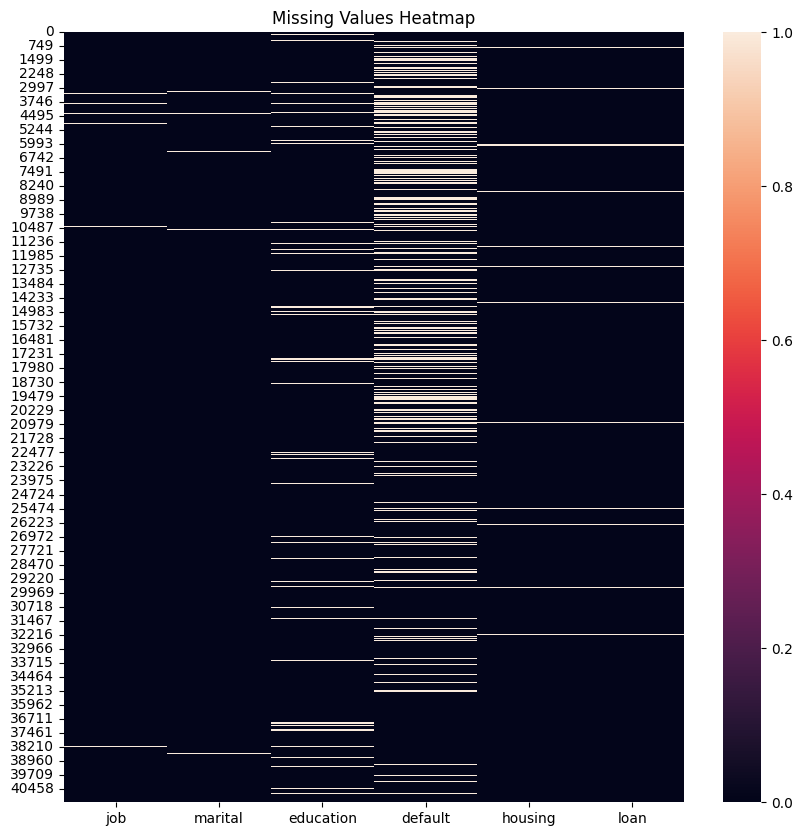

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Missing Values Heatmap')
sns.heatmap(df[['job', 'marital', 'education', 'default', 'housing', 'loan']].isna())

These missing values may happen due to some underlying reasons such as:

1. Customers refused to disclose their information to the bank

2. Customers may not take loan in the this bank, therefore the `default` feature has a lot of missing values

3. Telemarketing data and retail banking data are not synchronized

*note: based on the heatmap, `housing` and `loan` may have connection with each other.

### **2.3 Outliers Handling**

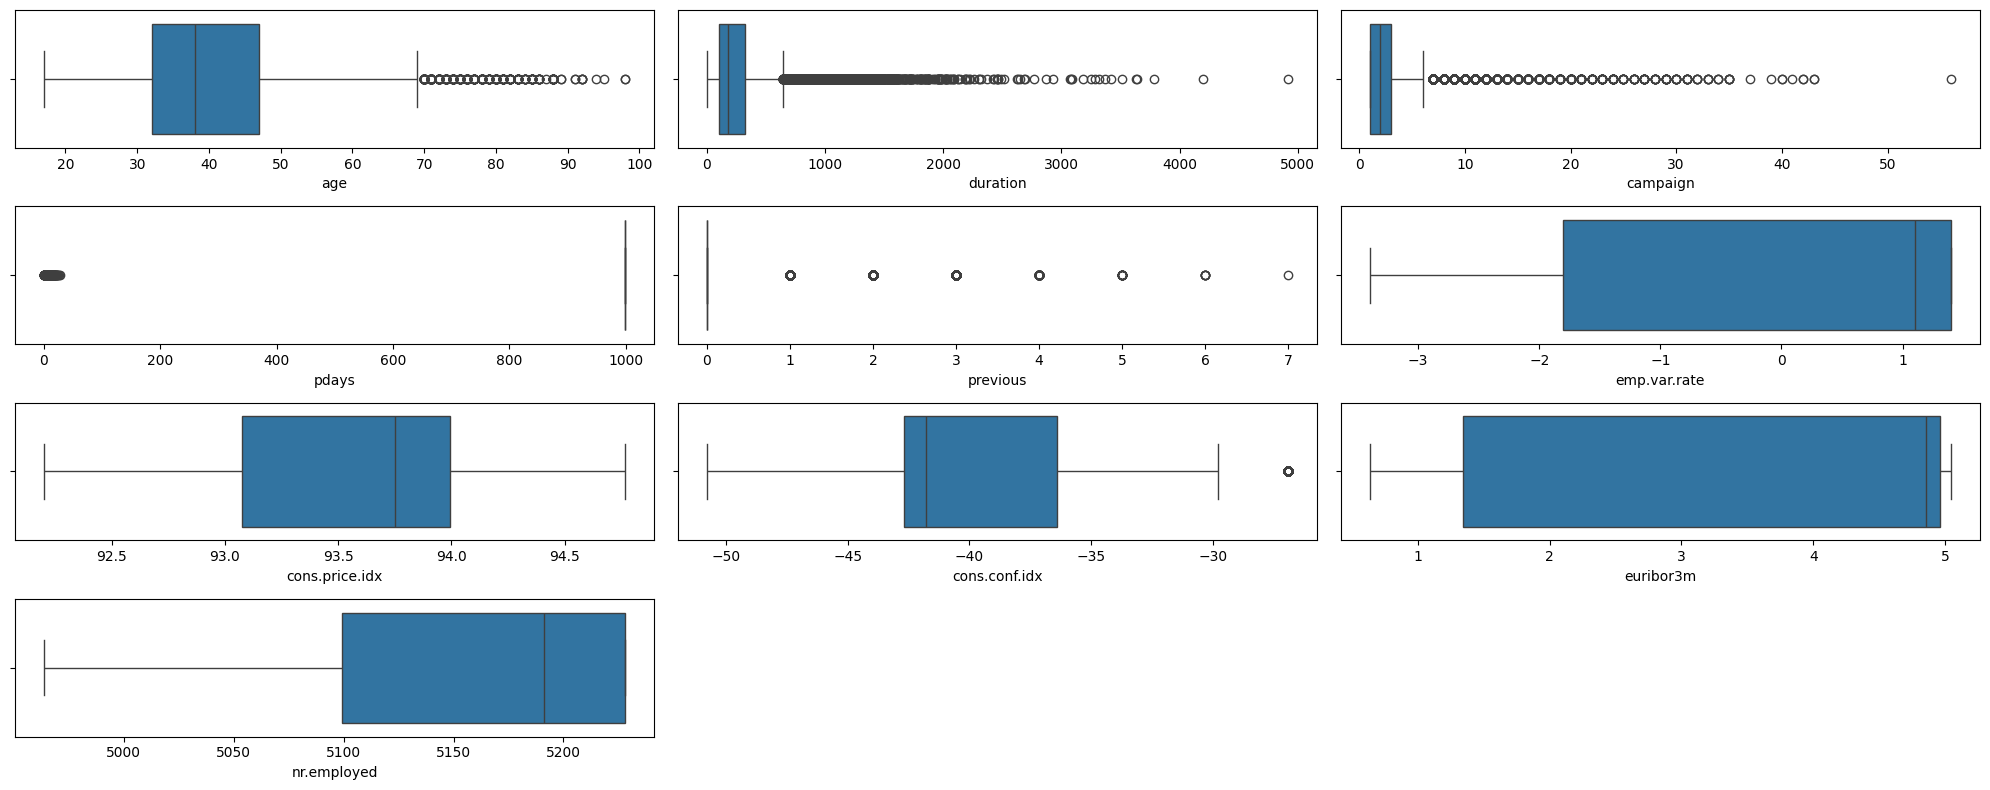

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(20, 8))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12 = axes.flatten()
sns.boxplot(data=df, x='age',ax=ax1)
sns.boxplot(data=df, x='duration',ax=ax2)
sns.boxplot(data=df, x='campaign',ax=ax3)
sns.boxplot(data=df, x='pdays',ax=ax4)
sns.boxplot(data=df, x='previous',ax=ax5)
sns.boxplot(data=df, x='emp.var.rate',ax=ax6)
sns.boxplot(data=df, x='cons.price.idx',ax=ax7)
sns.boxplot(data=df, x='cons.conf.idx',ax=ax8)
sns.boxplot(data=df, x='euribor3m',ax=ax9)
sns.boxplot(data=df, x='nr.employed',ax=ax10)
fig.delaxes(ax11)
fig.delaxes(ax12)
plt.tight_layout()
plt.show()

The outliers present in `age`, `duration`, `campaign`, `pdays`, `previous`, and `cons.conf.idx` features.

In [ ]:
(df['duration']>1800).value_counts()

duration
False    41075
True       101
Name: count, dtype: int64

In [ ]:
(df['campaign']>15).value_counts()

campaign
False    40821
True       355
Name: count, dtype: int64

In [ ]:
df = df[(df['campaign'] <= 15) & (df['duration'] <= 1800)].reset_index()

`We remove some of the outliers due:`
- Excessive duration call, 30 minutes seems reasonable
- lots of campaigns

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40720 entries, 0 to 40719
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           40720 non-null  int64  
 1   age             40720 non-null  int64  
 2   job             40395 non-null  object 
 3   marital         40642 non-null  object 
 4   education       39008 non-null  object 
 5   default         32234 non-null  object 
 6   housing         39737 non-null  object 
 7   loan            39737 non-null  object 
 8   contact         40720 non-null  object 
 9   month           40720 non-null  object 
 10  day_of_week     40720 non-null  object 
 11  duration        40720 non-null  int64  
 12  campaign        40720 non-null  int64  
 13  pdays           40720 non-null  int64  
 14  previous        40720 non-null  int64  
 15  poutcome        40720 non-null  object 
 16  emp.var.rate    40720 non-null  float64
 17  cons.price.idx  40720 non-null 

After the duplicates and outliers removed, the cleaned data is 40,720 rows data from 41,188.

### **2.4 Exploratory Data Analysis (EDA)**

#### 2.4.1 Target imbalance detection



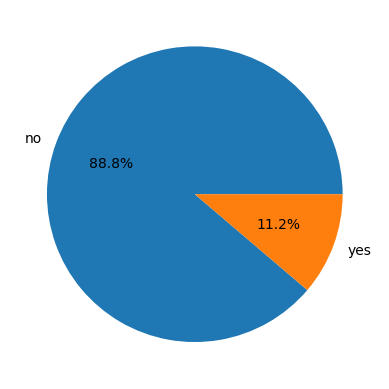

In [ ]:
plt.pie(df['y'].value_counts(), labels=['no', 'yes'], autopct='%1.1f%%')
plt.show()

We can imply from the chart that the target has a class imbalance with 11.3% of the customers making subscription and 88.7% who do not.

**Bivariate Distribution of Target variable and Features**

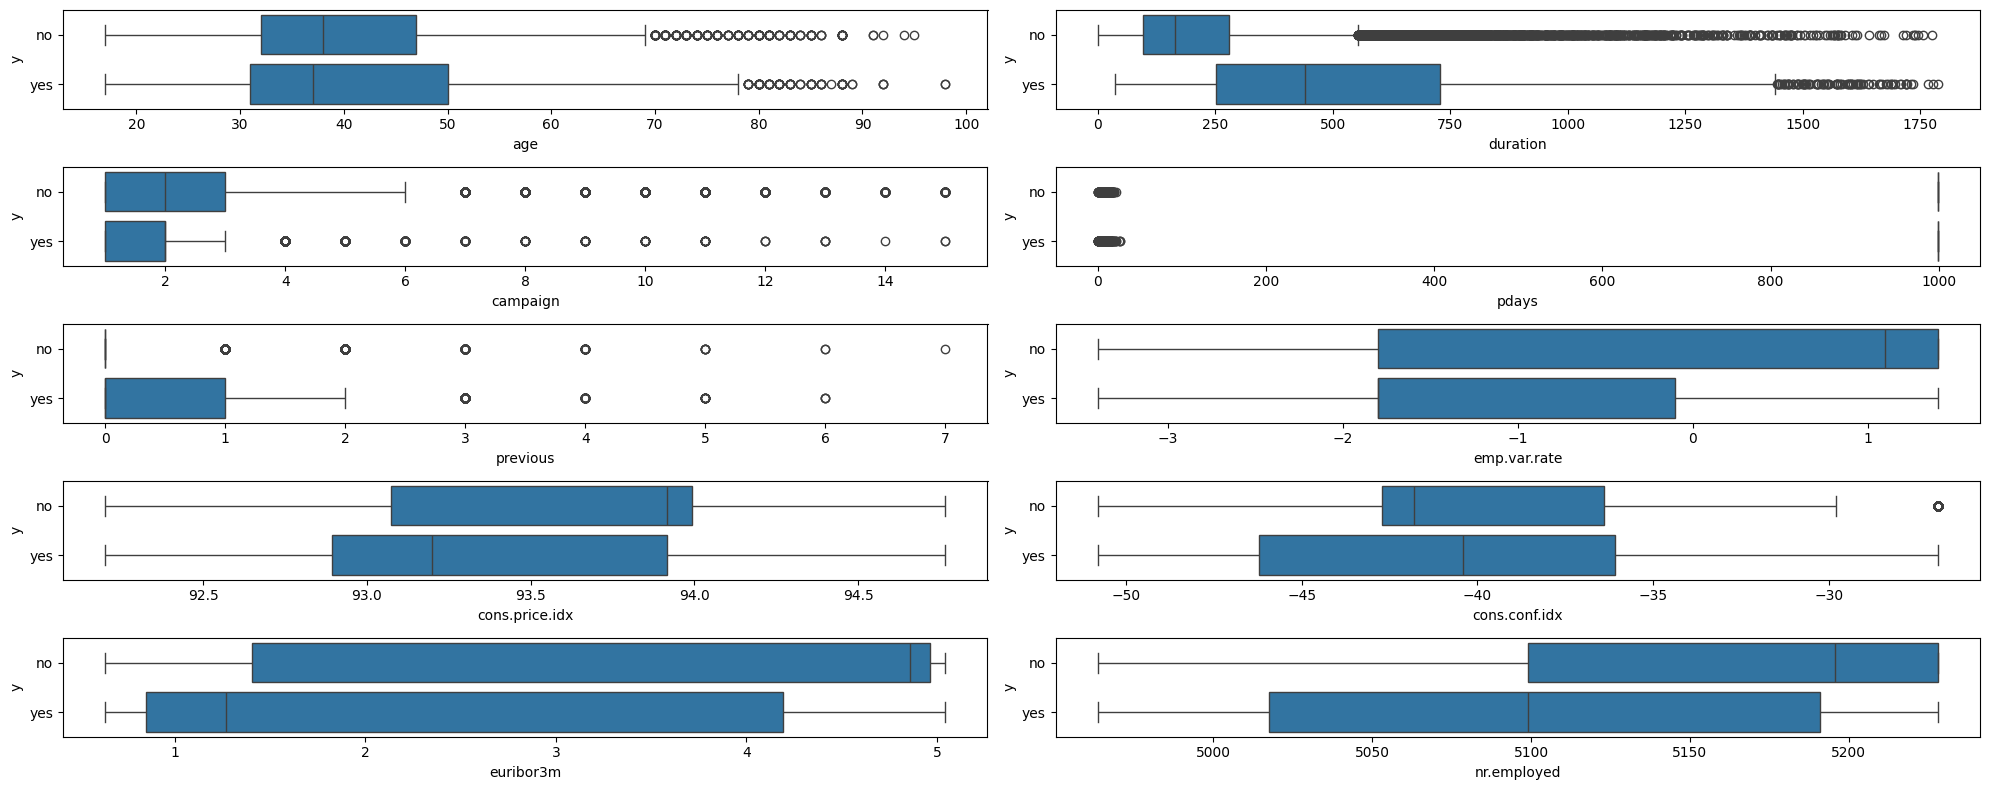

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(20, 8))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10 = axes.flatten()
sns.boxplot(data=df, x='age',y='y',ax=ax1)
sns.boxplot(data=df, x='duration',y='y',ax=ax2)
sns.boxplot(data=df, x='campaign',y='y',ax=ax3)
sns.boxplot(data=df, x='pdays',y='y',ax=ax4)
sns.boxplot(data=df, x='previous',y='y',ax=ax5)
sns.boxplot(data=df, x='emp.var.rate',y='y',ax=ax6)
sns.boxplot(data=df, x='cons.price.idx',y='y',ax=ax7)
sns.boxplot(data=df, x='cons.conf.idx',y='y',ax=ax8)
sns.boxplot(data=df, x='euribor3m',y='y',ax=ax9)
sns.boxplot(data=df, x='nr.employed',y='y',ax=ax10)

plt.tight_layout()
plt.show()

The farther the median and IQR, the higher the discriminative power.
- `duration`, `euribor`, and `emp.var.rate`, `cons.price.idx` and `nr.employ` have high discriminative power.
- `age`, `previous`, `campaign`, and `pdays` have high overlap distributions  (low discriminative power) followed by `cons.conf.idx` overlapping moderately



#### 2.4.2 Personal data excluding default

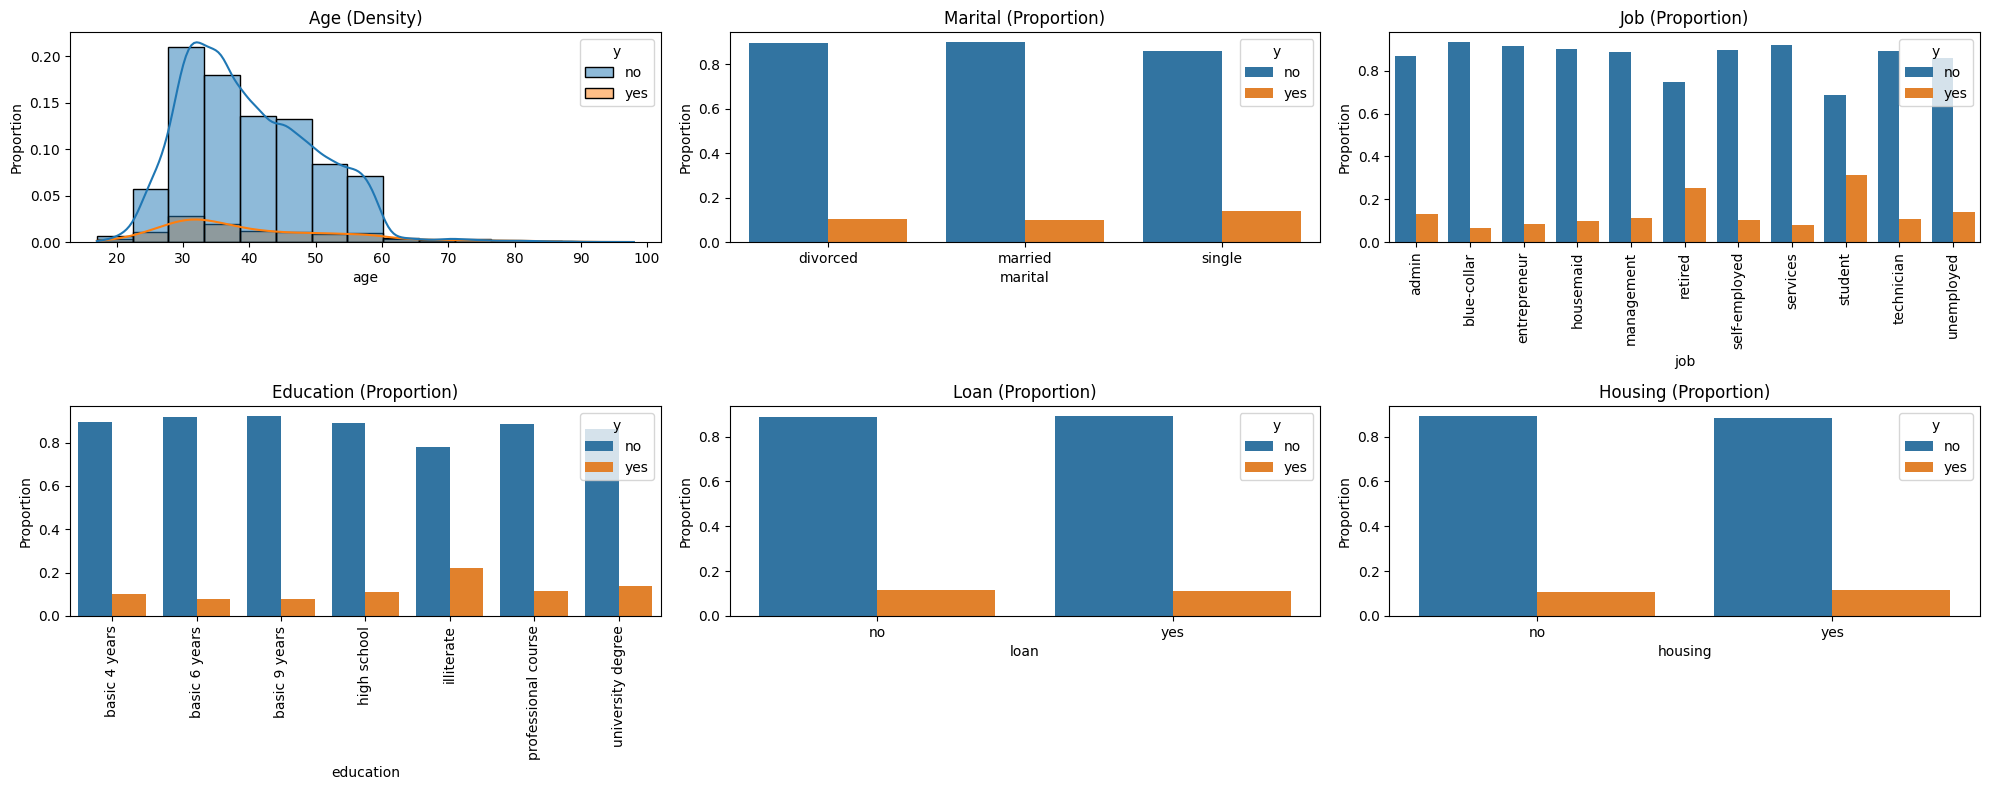

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

sns.histplot(data=df, x='age', hue='y', kde=True, bins=15, ax=ax1, stat='proportion')

def plot_proportion(feature, ax):
    prop = (
        df.groupby(feature)['y']
        .value_counts(normalize=True)
        .rename('proportion')
        .reset_index()
    )

    sns.barplot(
        data=prop,
        x=feature,
        y='proportion',
        hue='y',
        ax=ax
    )

    ax.set_ylabel("Proportion")

plot_proportion('marital', ax2)
plot_proportion('job', ax3)
plot_proportion('education', ax4)
plot_proportion('loan', ax5)
plot_proportion('housing', ax6)

ax1.set_title('Age (Density)')
ax2.set_title('Marital (Proportion)')
ax3.set_title('Job (Proportion)')
ax4.set_title('Education (Proportion)')
ax5.set_title('Loan (Proportion)')
ax6.set_title('Housing (Proportion)')

ax3.tick_params(axis='x', labelrotation=90)
ax4.tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

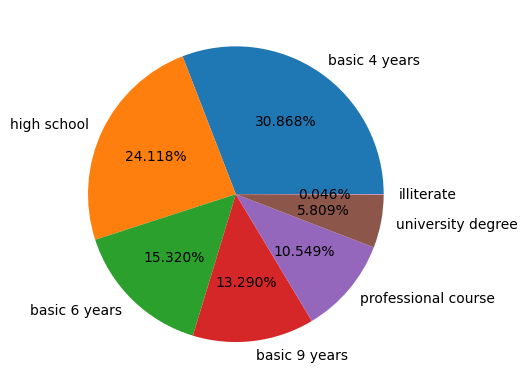

In [ ]:
plt.pie(df['education'].value_counts(), labels=['basic 4 years', 'high school', 'basic 6 years', 'basic 9 years', 'professional course', 'university degree', 'illiterate'], autopct='%1.3f%%')
plt.show()

- In all of the plots, "no" class dominates "yes" class
- This shows strong class imbalance

- Age --> Customers in late 20s to early 30s shows higher interest in subscribing deposit
- Marital --> Customers with `marital` status `single` tend to subscribe to deposit more
- Job --> Customers who are `student` and customers who have `retired` tend to subscribe to deposit more
- Education --> Customers who pursued `university degree` tend to subscribe to deposit more
- Loan and Housing have similar distribution proportion within the target, therefore inferential statistic is used to differentiate them

#### 2.4.3 Default

Since the default variable contains more than 20% missing values, these missing entries were recoded as "unknown" to allow for a clearer analysis of the category distribution within the dataset.

In [ ]:
df_default=df.copy()
df_default['default'] = df_default['default'].fillna('unknown')


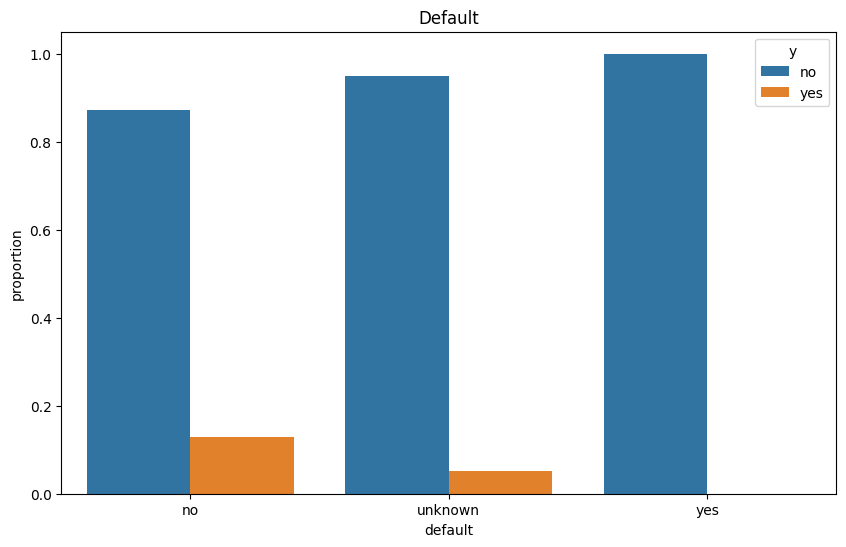

In [ ]:
default_reset = (
    df_default
    .groupby('default')['y']
    .value_counts(normalize=True)
    .reset_index(name='proportion')
)

plt.figure(figsize=(10,6))

sns.barplot(
    data=default_reset,
    x='default',
    y='proportion',
    hue='y'
)

plt.title("Default")
plt.show()


`default` feature shows strong class imbalance with "no" target class dominating.

In [ ]:
df_default['default'].value_counts()

default
no         32231
unknown     8486
yes            3
Name: count, dtype: int64

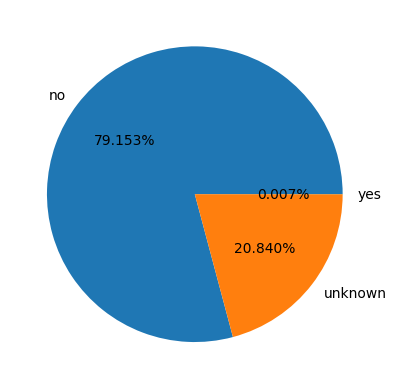

In [ ]:
plt.pie(df_default['default'].value_counts(), labels=['no', 'unknown','yes'], autopct='%1.3f%%')
plt.show()

`default` feature shows strong class imbalance, with the 'yes' class being extremely rare, only 3 observations, representing approximately 0.007% of the total dataset

#### 2.4.4 Related to last campaign contact

In [ ]:
month_order = ['jan','feb','mar','apr','may','jun',
               'jul','aug','sep','oct','nov','dec']
df['month'] = pd.Categorical(df['month'],
                                   categories=month_order,
                                   ordered=True)

day_order = ['mon', 'tue', 'wed', 'thu', 'fri']
df['day_of_week'] = pd.Categorical(df['day_of_week'],
                                   categories=day_order,
                                   ordered=True)

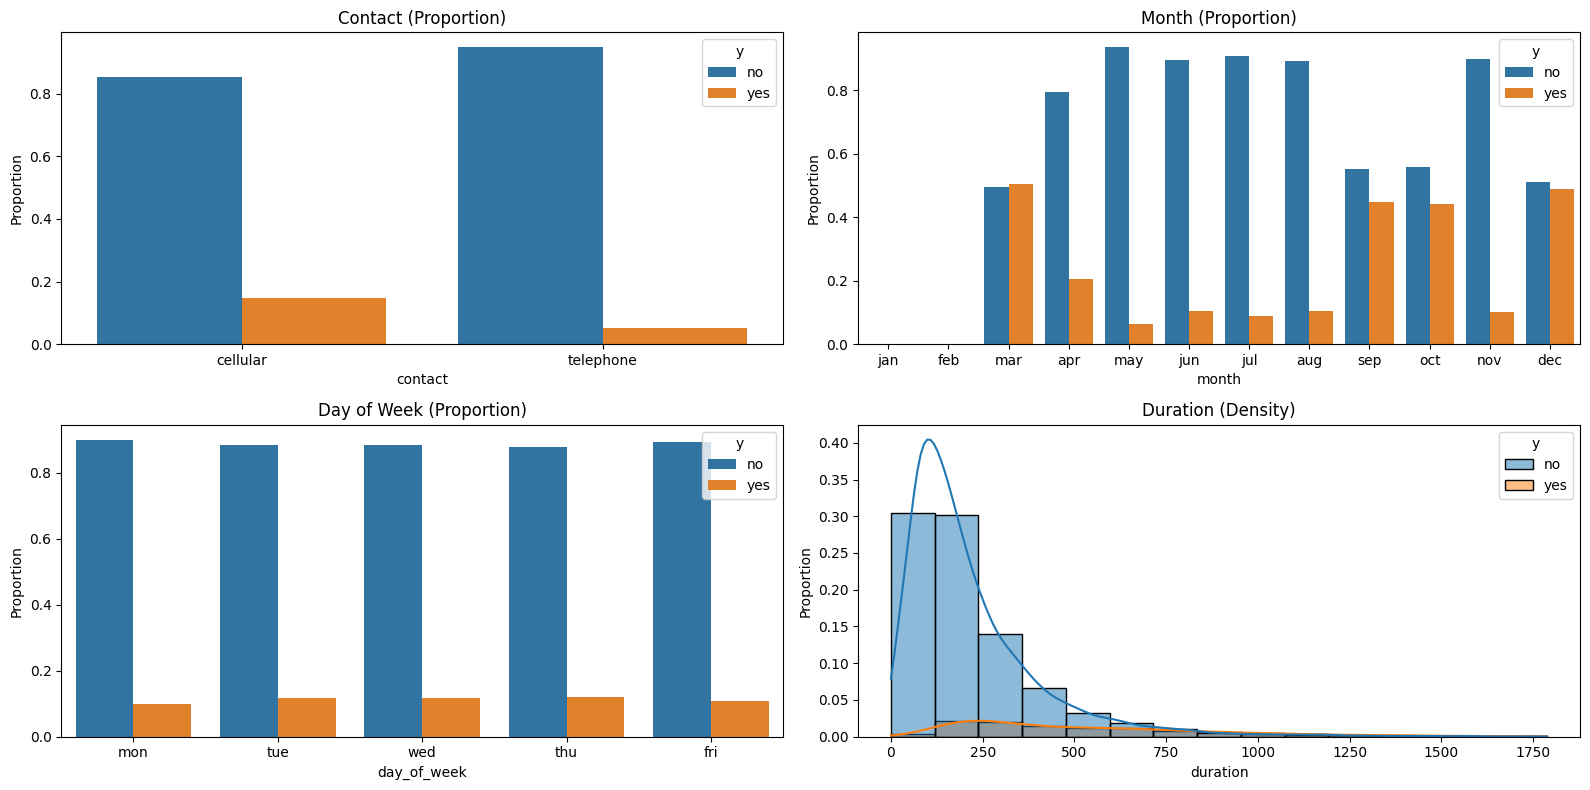

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
ax1, ax2, ax3, ax4 = axes.flatten()

sns.histplot(data=df, x='duration', hue='y', kde=True, bins=15, ax=ax4, stat='proportion')

def plot_proportion(feature, ax):
    prop = (
        df.groupby(feature)['y']
        .value_counts(normalize=True)
        .rename('proportion')
        .reset_index()
    )

    sns.barplot(
        data=prop,
        x=feature,
        y='proportion',
        hue='y',
        ax=ax
    )

    ax.set_ylabel("Proportion")

plot_proportion('contact', ax1)
plot_proportion('month', ax2)
plot_proportion('day_of_week', ax3)

ax1.set_title('Contact (Proportion)')
ax2.set_title('Month (Proportion)')
ax3.set_title('Day of Week (Proportion)')
ax4.set_title('Duration (Density)')

# ax3.tick_params(axis='x', labelrotation=90)
# ax4.tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()

The features related to the last campaign contact also show strong class imbalance.

- `contact` --> Customers who are contacted cellular tend to subscribe to deposit more
- `month` --> Customer are contacted in March and December tend to subscribe to deposit more
- `day_of_week` --> all of the days have similar distribution proportion within the target, therefore inferential statistic is used to differentiate them.
- `duration` --> Phone call duration is dominated by shorter calls rather than longer ones

#### 2.4.5 Pdays

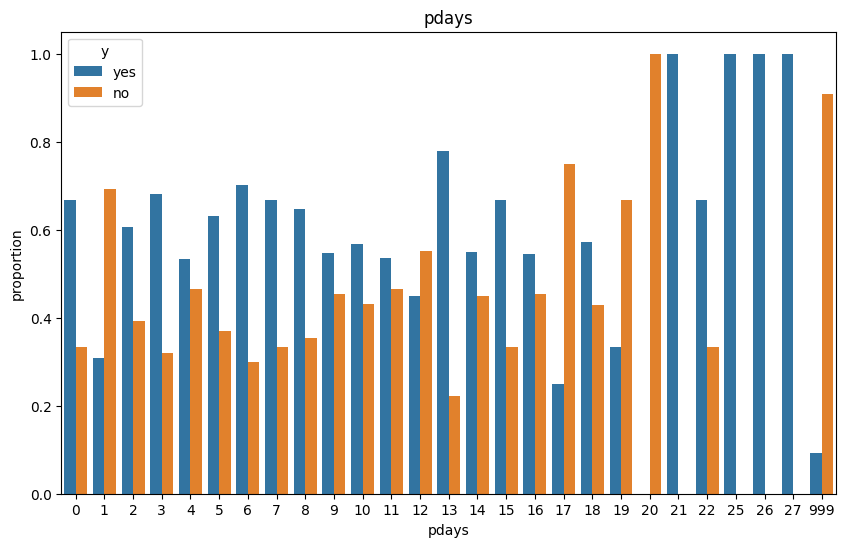

In [ ]:
pdays_reset = (
    df
    .groupby('pdays')['y']
    .value_counts(normalize=True)
    .reset_index(name='proportion')
)
plt.figure(figsize=(10,6))

sns.barplot(
    data=pdays_reset,
    x='pdays',
    y='proportion',
    hue='y'
)

plt.title("pdays")
plt.show()

- Most customers that have never contacted before (999 pdays) do not subscribe to the deposit product, however customers that have contacted recently are more likely to subscribe.

#### 2.4.6 Other attributes

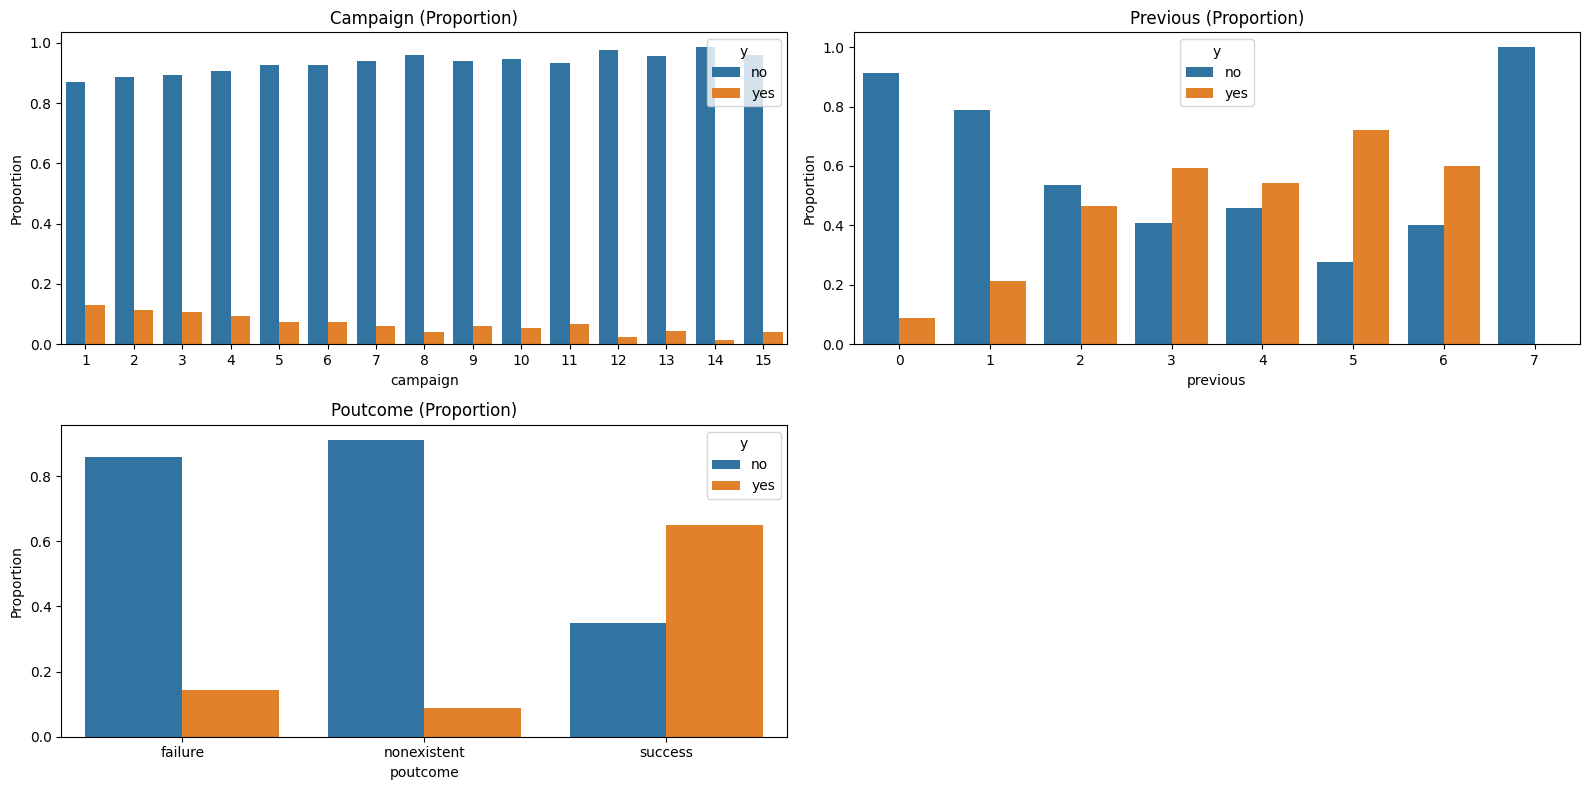

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
ax1, ax2, ax3, ax4 = axes.flatten()

def plot_proportion(feature, ax):
    prop = (
        df.groupby(feature)['y']
        .value_counts(normalize=True)
        .rename('proportion')
        .reset_index()
    )

    sns.barplot(
        data=prop,
        x=feature,
        y='proportion',
        hue='y',
        ax=ax
    )

    ax.set_ylabel("Proportion")

plot_proportion('campaign', ax1)
plot_proportion('previous', ax2)
plot_proportion('poutcome', ax3)

ax1.set_title('Campaign (Proportion)')
ax2.set_title('Previous (Proportion)')
ax3.set_title('Poutcome (Proportion)')


# ax3.tick_params(axis='x', labelrotation=90)
# ax4.tick_params(axis='x', labelrotation=90)
fig.delaxes(ax4)
plt.tight_layout()
plt.show()

- `campaign` --> customers who have been contacted less than 4 times for this campaign tend to subscribe to deposit more
- `previous` --> Majority of customers subscribe to deposit on the fifth contact before the current campaign
- `poutcome` --> Majority of customers who have subscribed deposit previously are willing to subscribe in the next campaign.

#### 2.4.7 Socioeconomic factors

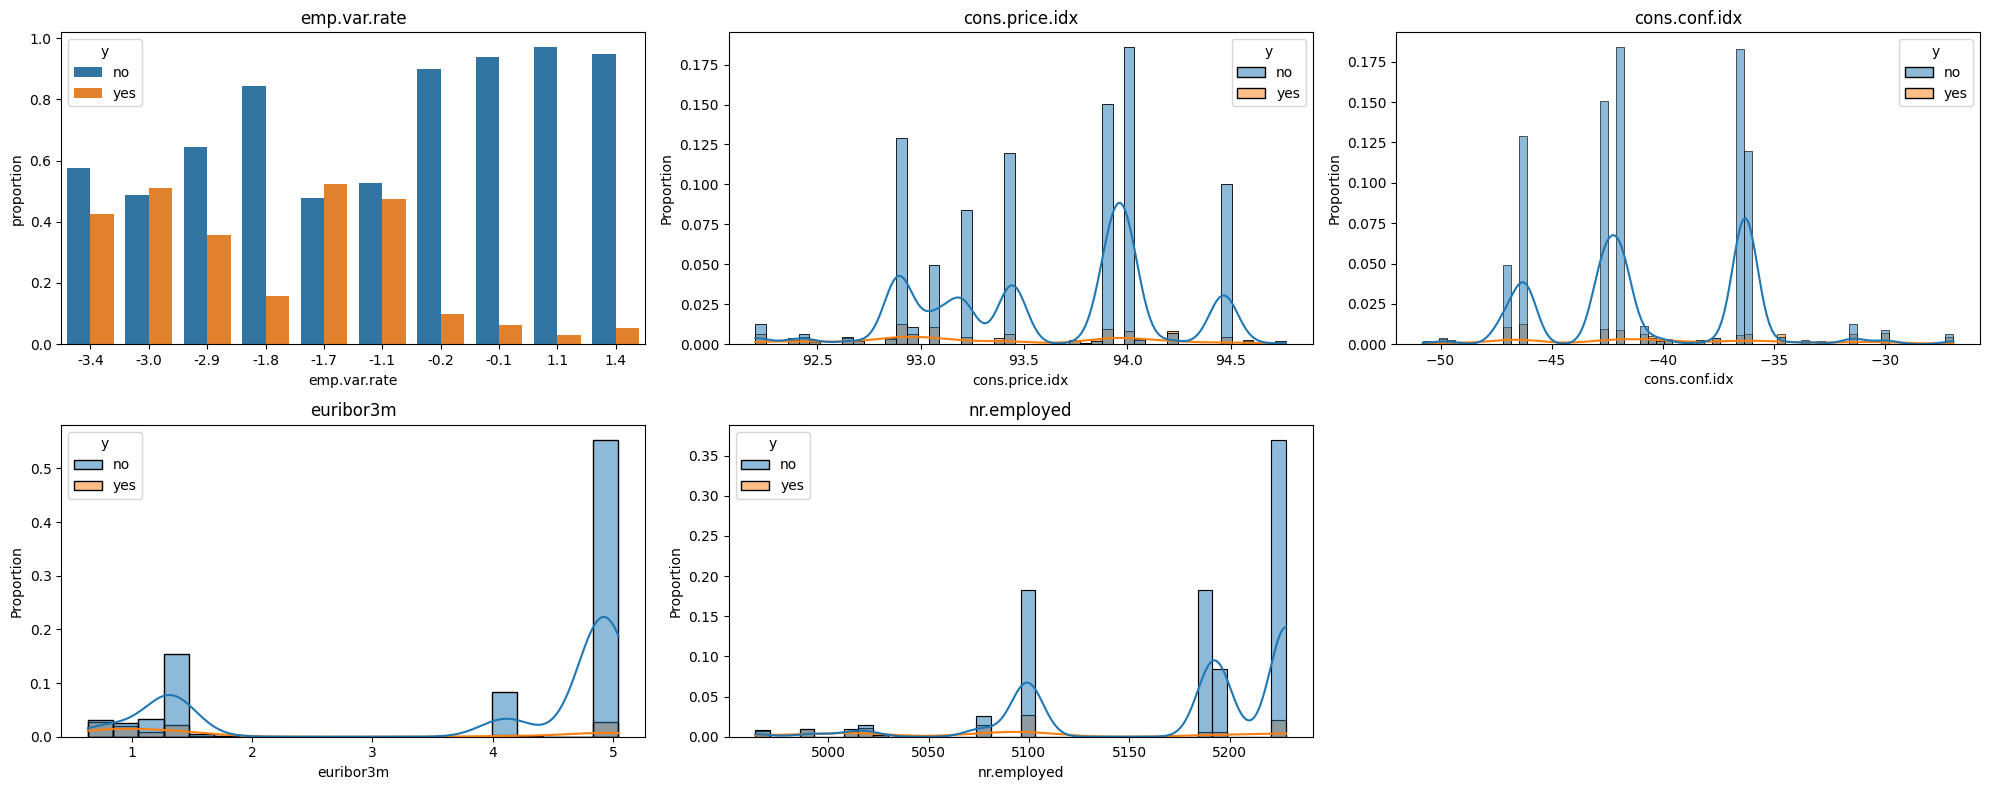

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

emp_reset = (
    df
    .groupby('emp.var.rate')['y']
    .value_counts(normalize=True)
    .reset_index(name='proportion')
)

sns.barplot(
    data=emp_reset,
    x='emp.var.rate',
    y='proportion',
    hue='y', ax=ax1
)

sns.histplot(data=df, x='cons.price.idx', hue='y', kde=True, ax=ax2, stat='proportion')
sns.histplot(data=df, x='cons.conf.idx',  hue='y', kde=True, ax=ax3, stat='proportion')
sns.histplot(data=df, x='euribor3m',      hue='y', kde=True, ax=ax4, stat='proportion')
sns.histplot(data=df, x='nr.employed',    hue='y', kde=True, ax=ax5, stat='proportion')

ax1.set_title('emp.var.rate')
ax2.set_title('cons.price.idx')
ax3.set_title('cons.conf.idx')
ax4.set_title('euribor3m')
ax5.set_title('nr.employed')
fig.delaxes(ax6)

plt.tight_layout()
plt.show()

- Subcriptions to deposit appear more frequent when economic indicators `employment variation rate` are lower and
`number employment` higher

- `euribor3m` --> The highest proportion of success deposits occurs when the interest rate is higher

- `cons.conf.idx` --> Subcriptions cluster at specific index, suggesting that middle-to-low confidence levels may drive people toward the perceived safety of a term deposit

- `cons.price.idx` --> Customers with the CPI of around 93 and around 94 shows higher proportion of subscribing deposits


### 2.5 Analysis of the Impact of the Financial Crisis on Term-Deposit Subscriptions in Portuguese Bank

In [ ]:
df_analysis = df.copy()

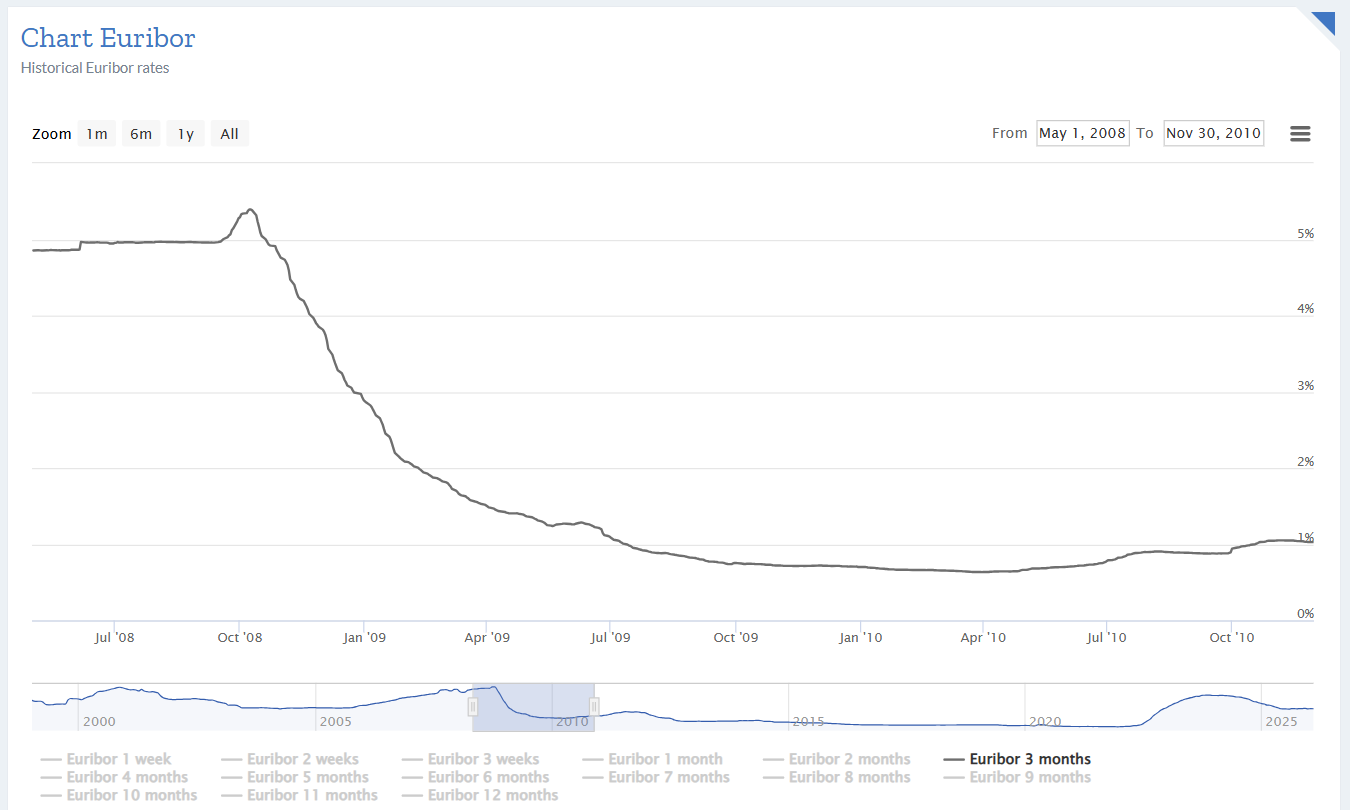

- Pre-crisis interest rate: The rate maintained a steady percentage near 5%, indicating a high-interest environment prior to the global financial crash

- Peak interest rate: A sharp spike in October 2008, likely driven by the immedicate liquidity crisis

- Collapse interest rate: The rate plummeting until mid-2009 from 5% to 1% in less than a year

- Early recovery: Toward the end of 2010, an upward trend is visible, signaling a cautious return to market

Time series  is needed to support this analysis, therefore the existing data is combined with [`euribor3m` data](https://www.euribor-rates.eu/en/euribor-charts/) and `cons.price.idx`-`cons.conf.idx` quarterly data to determine the data year

In [ ]:
df_analysis.groupby('month')['euribor3m'].unique()

month
jan                                                                                                                                                                                                                                                                                                                                                                  []
feb                                                                                                                                                                                                                                                                                                                                                                  []
mar                                                                                                       [1.811, 1.799, 1.778, 1.757, 1.726, 1.703, 1.687, 1.663, 1.65, 1.64, 1.629, 1.614, 1.602, 1.584, 1.574, 1.56, 1.556, 1.548, 1.538, 1.531, 1.52, 1.51, 0.655, 0.654, 0.653, 0.652, 0.651, 0.65, 0.649, 0.646, 0.644, 0.643, 0.639, 0.637, 0.635, 0.636, 0.634]
apr                                                                                                                                                             [1.498, 1.483, 1.479, 1.466, 1.453, 1.445, 1.435, 1.423, 1.415, 1.41, 1.405, 1.406, 1.4, 1.392, 1.384, 1.372, 1.365, 0.635, 0.638, 0.639, 0.64, 0.642, 0.644, 0.643, 0.645, 0.646, 0.654, 0.659, 0.663]
may                                                                                                                   [4.857, 4.856, 4.855, 4.859, 4.86, 4.858, 4.864, 1.354, 1.344, 1.334, 1.327, 1.313, 1.299, 1.291, 1.281, 1.266, 1.25, 1.244, 1.259, 1.264, 1.27, 0.668, 0.672, 0.677, 0.682, 0.683, 0.684, 0.685, 0.688, 0.69, 0.692, 0.695, 0.697, 0.699, 0.701]
jun                                                   [4.865, 4.864, 4.866, 4.967, 4.961, 4.959, 4.958, 4.96, 4.962, 4.955, 4.947, 1.266, 1.262, 1.26, 1.268, 1.281, 1.286, 1.252, 1.244, 1.235, 1.224, 1.215, 1.206, 1.099, 0.702, 0.704, 0.707, 0.711, 0.713, 0.715, 0.719, 0.72, 0.723, 0.727, 0.729, 0.732, 0.733, 0.737, 0.739, 0.742, 0.748, 0.754, 0.761, 0.767]
jul    [4.955, 4.956, 4.966, 4.959, 4.96, 4.962, 4.963, 4.961, 4.957, 4.958, 4.968, 1.085, 1.072, 1.059, 1.048, 1.044, 1.029, 1.018, 1.007, 0.996, 0.979, 0.969, 0.944, 0.937, 0.933, 0.927, 0.921, 0.914, 0.908, 0.903, 0.899, 0.782, 0.79, 0.793, 0.797, 0.802, 0.81, 0.822, 0.827, 0.835, 0.84, 0.846, 0.861, 0.87, 0.876, 0.881, 0.884, 0.885, 0.889, 0.893, 0.896]
aug                                                                                       [4.97, 4.968, 4.967, 4.966, 4.965, 4.964, 4.963, 4.962, 0.884, 0.883, 0.881, 0.879, 0.873, 0.869, 0.861, 0.859, 0.854, 0.851, 0.849, 0.843, 0.838, 0.834, 0.829, 0.825, 0.821, 0.898, 0.899, 0.9, 0.904, 0.905, 0.903, 0.896, 0.895, 0.894, 0.891, 0.89, 0.889, 0.888, 0.886]
sep                                                                                                                                              [0.819, 0.813, 0.809, 0.803, 0.797, 0.788, 0.781, 0.778, 0.773, 0.771, 0.77, 0.768, 0.766, 0.762, 0.755, 0.749, 0.743, 0.741, 0.739, 0.75, 0.753, 0.886, 0.884, 0.883, 0.882, 0.881, 0.88, 0.879, 0.878, 0.877, 0.876]
oct                             [5.045, 5.0, 4.968, 4.936, 4.921, 4.918, 4.912, 4.86, 4.827, 4.794, 4.76, 0.754, 0.752, 0.744, 0.74, 0.741, 0.743, 0.742, 0.739, 0.737, 0.735, 0.733, 0.73, 0.731, 0.728, 0.724, 0.722, 0.72, 0.942, 0.953, 0.956, 0.959, 0.965, 0.972, 0.977, 0.982, 0.985, 0.987, 0.993, 1.0, 1.008, 1.016, 1.025, 1.029, 1.032, 1.037, 1.043, 1.045]
nov                                                                                                 [4.733, 4.7, 4.663, 4.592, 4.474, 4.406, 4.343, 4.286, 4.245, 4.223, 4.191, 4.153, 4.12, 4.076, 4.021, 3.901, 3.879, 3.853, 0.722, 0.72, 0.719, 0.716, 0.715, 0.714, 0.718, 1.047, 1.05, 1.049, 1.048, 1.046, 1.044, 1.041, 1.04, 1.039, 1.035, 1.03, 1.031, 1.028]
dec                               

In [ ]:
df_analysis['year'] = np.nan


# MAY
may = df_analysis['month'] == 'may'
df_analysis.loc[may & df_analysis['euribor3m'].between(4, 5), 'year'] = 2008
df_analysis.loc[may & df_analysis['euribor3m'].between(1.1, 1.4), 'year'] = 2009
df_analysis.loc[may & df_analysis['euribor3m'].between(0.5, 0.8), 'year'] = 2010

# MAR
mar = df_analysis['month'] == 'mar'
df_analysis.loc[mar & df_analysis['euribor3m'].between(1.4, 2), 'year'] = 2009
df_analysis.loc[mar & ~df_analysis['euribor3m'].between(1.4, 2), 'year'] = 2010

# APR
apr = df_analysis['month'] == 'apr'
df_analysis.loc[apr & df_analysis['euribor3m'].between(1.3, 1.5), 'year'] = 2009
df_analysis.loc[apr & ~df_analysis['euribor3m'].between(1.3, 1.5), 'year'] = 2010

# JUL
jul = df_analysis['month'] == 'jul'
df_analysis.loc[jul & df_analysis['euribor3m'].between(4.8, 5), 'year'] = 2008
df_analysis.loc[jul & np.isclose(df_analysis['emp.var.rate'], -2.9), 'year'] = 2009
df_analysis.loc[jul & np.isclose(df_analysis['emp.var.rate'], -1.7), 'year'] = 2010

# JUN
jun = df_analysis['month'] == 'jun'
df_analysis.loc[jun & df_analysis['euribor3m'].between(4.8, 5), 'year'] = 2008
df_analysis.loc[jun & df_analysis['euribor3m'].between(1, 1.3), 'year'] = 2009
df_analysis.loc[jun & df_analysis['euribor3m'].between(0.7, 0.8), 'year'] = 2010

# AUG
aug = df_analysis['month'] == 'aug'
df_analysis.loc[aug & df_analysis['euribor3m'].between(4.8, 5), 'year'] = 2008
df_analysis.loc[aug & np.isclose(df_analysis['emp.var.rate'], -2.9), 'year'] = 2009
df_analysis.loc[aug & np.isclose(df_analysis['emp.var.rate'], -1.7), 'year'] = 2010

# SEPT
sep = df_analysis['month'] == 'sep'
df_analysis.loc[sep & df_analysis['euribor3m'].between(0.7, 0.82), 'year'] = 2009
df_analysis.loc[sep & ~df_analysis['euribor3m'].between(0.7, 0.82), 'year'] = 2010

# OCT
oct = df_analysis['month'] == 'oct'
df_analysis.loc[oct & df_analysis['euribor3m'].between(4.7, 5.1), 'year'] = 2008
df_analysis.loc[oct & df_analysis['euribor3m'].between(0.7, 0.8), 'year'] = 2009
df_analysis.loc[oct & df_analysis['euribor3m'].between(0.9, 1.1), 'year'] = 2010

# NOV
nov = df_analysis['month'] == 'nov'
df_analysis.loc[nov & df_analysis['euribor3m'].between(3, 5), 'year'] = 2008
df_analysis.loc[nov & np.isclose(df_analysis['emp.var.rate'], -3.4), 'year'] = 2009
df_analysis.loc[nov & np.isclose(df_analysis['emp.var.rate'], -1.1), 'year'] = 2010

# DEC
dec = df_analysis['month'] == 'dec'
df_analysis.loc[dec & df_analysis['euribor3m'].between(3, 4), 'year'] = 2008
df_analysis.loc[dec & ~df_analysis['euribor3m'].between(3, 4), 'year'] = 2009


df_analysis['year'] = df_analysis['year'].astype('Int64')



In [ ]:
df_analysis.head(5)

index  age        job  marital      education default housing loan  \
0      0   56  housemaid  married  basic 4 years      no      no   no   
1      1   57   services  married    high school     NaN      no   no   
2      2   37   services  married    high school      no     yes   no   
3      3   40      admin  married  basic 6 years      no      no   no   
4      4   56   services  married    high school      no      no  yes   

     contact month day_of_week  duration  campaign  pdays  previous  \
0  telephone   may         mon       261         1    999         0   
1  telephone   may         mon       149         1    999         0   
2  telephone   may         mon       226         1    999         0   
3  telephone   may         mon       151         1    999         0   
4  telephone   may         mon       307         1    999         0   

      poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  nonexistent           1.1          93.994          -36.4      4.857   
1  nonexistent           1.1          93.994          -36.4      4.857   
2  nonexistent           1.1          93.994          -36.4      4.857   
3  nonexistent           1.1          93.994          -36.4      4.857   
4  nonexistent           1.1          93.994          -36.4      4.857   

   nr.employed   y  year  
0       5191.0  no  2008  
1       5191.0  no  2008  
2       5191.0  no  2008  
3       5191.0  no  2008  
4       5191.0  no  2008

In [ ]:
month_order = ['jan','feb','mar','apr','may','jun',
               'jul','aug','sep','oct','nov','dec']

df_analysis['month'] = pd.Categorical(df_analysis['month'],
                                   categories=month_order,
                                   ordered=True)
df_analysis['date'] = pd.to_datetime(
    df_analysis['year'].astype(str) + '-' +
    df_analysis['month'].astype(str),
    format='%Y-%b'
)

df_analysis = df_analysis.sort_values('date')

#### 2.5.1 Socioeconomic Factors

##### Euribor

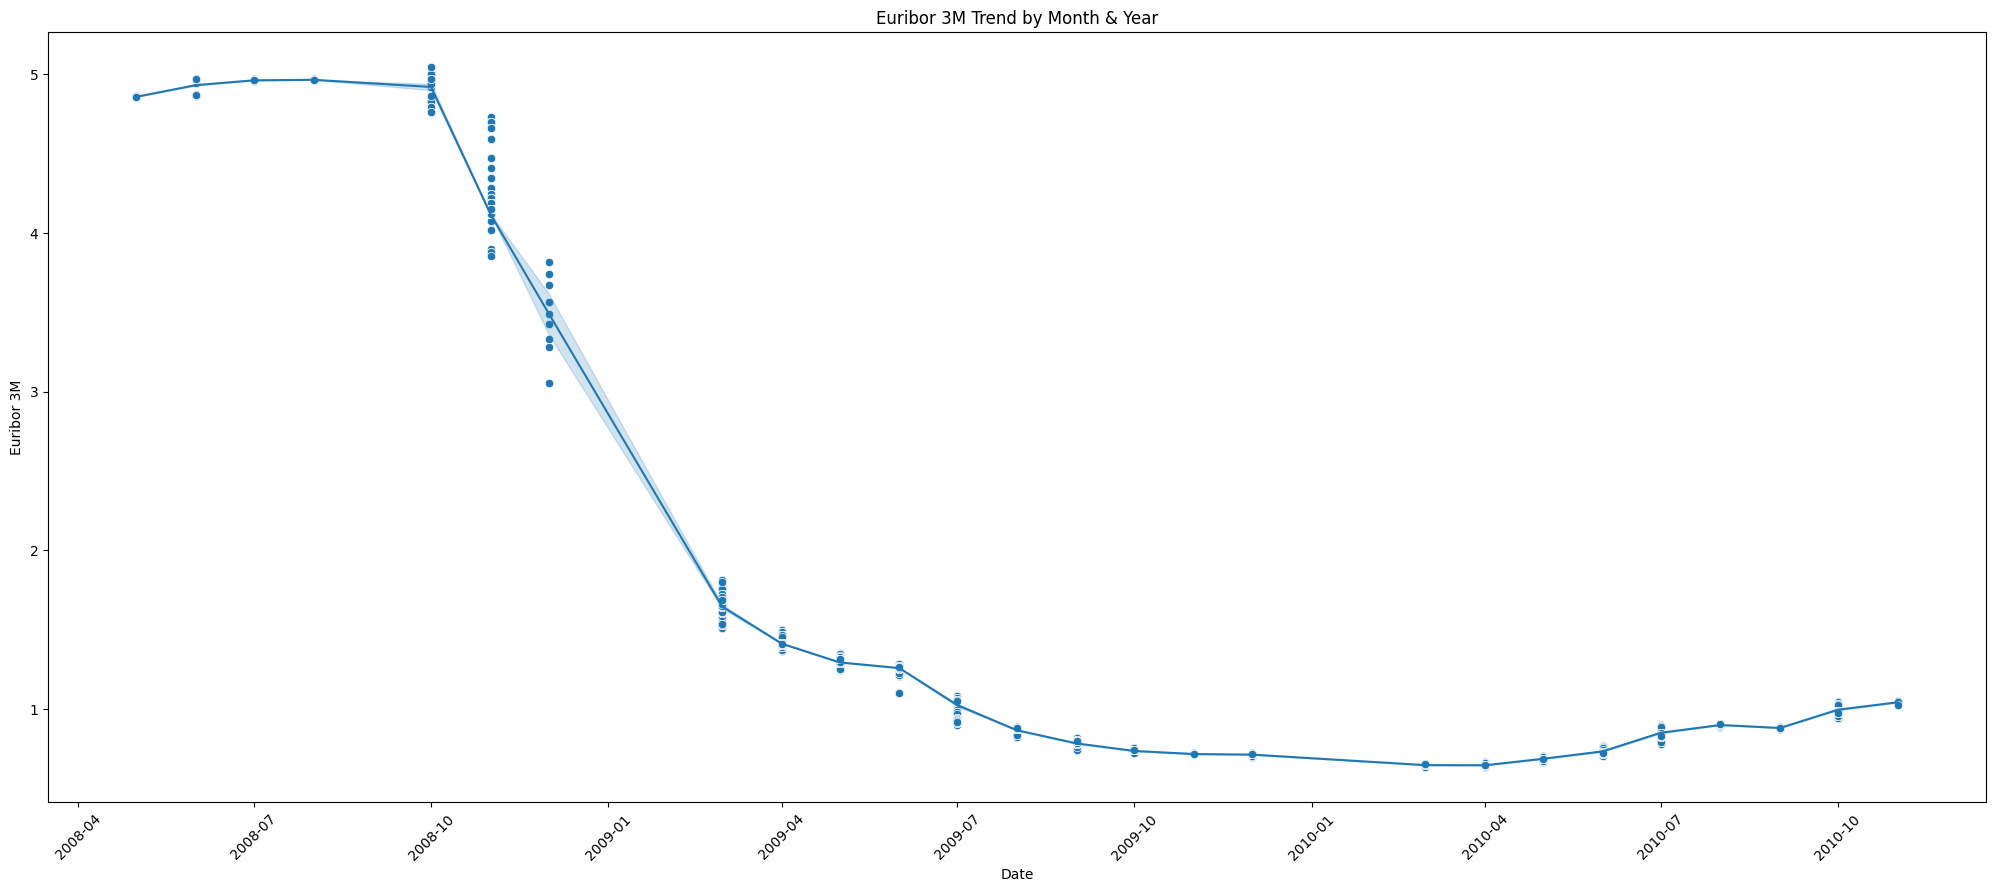

In [ ]:
plt.figure(figsize = (25,10))

sns.scatterplot(x = 'date' , y = 'euribor3m', data = df_analysis)
sns.lineplot(x = 'date', y = 'euribor3m', data = df_analysis)

plt.xticks(rotation=45)

plt.title("Euribor 3M Trend by Month & Year")
plt.xlabel("Date")
plt.ylabel("Euribor 3M")
plt.show()

The Euribor time series graph illustrates the interest rate levels at the time when the marketing campaigns were conducted. Based on the trend pattern and the corresponding timeline, the data reflects the impact of the European financial crisis, which also affected the Portuguese banking sector. Therefore, the time series can be segmented into three distinct phases: pre-crisis, crisis, and recovery.

This phase classification aligns with the [IMF's assessment](https://www.imf.org/en/news/articles/2015/09/14/01/49/pr09332?utm_source=chatgpt.com) that Europe experienced its deepest contraction during late 2008 and early 2009, reached its trough around mid-2009, and entered a slow and fragile recovery thereafter.

In [ ]:
df_analysis['phase'] = 'recovery'

df_analysis.loc[df_analysis['euribor3m'] >= 4.5, 'phase'] = 'pre_crisis'

df_analysis.loc[
    (df_analysis['euribor3m'].between(1.070, 4.5)) &
    (df_analysis['date'] < '2009-08-01'),
    'phase'
] = 'crisis'


In [ ]:
# df_analysis.to_csv("df_analysis_phase_edit_2.csv")

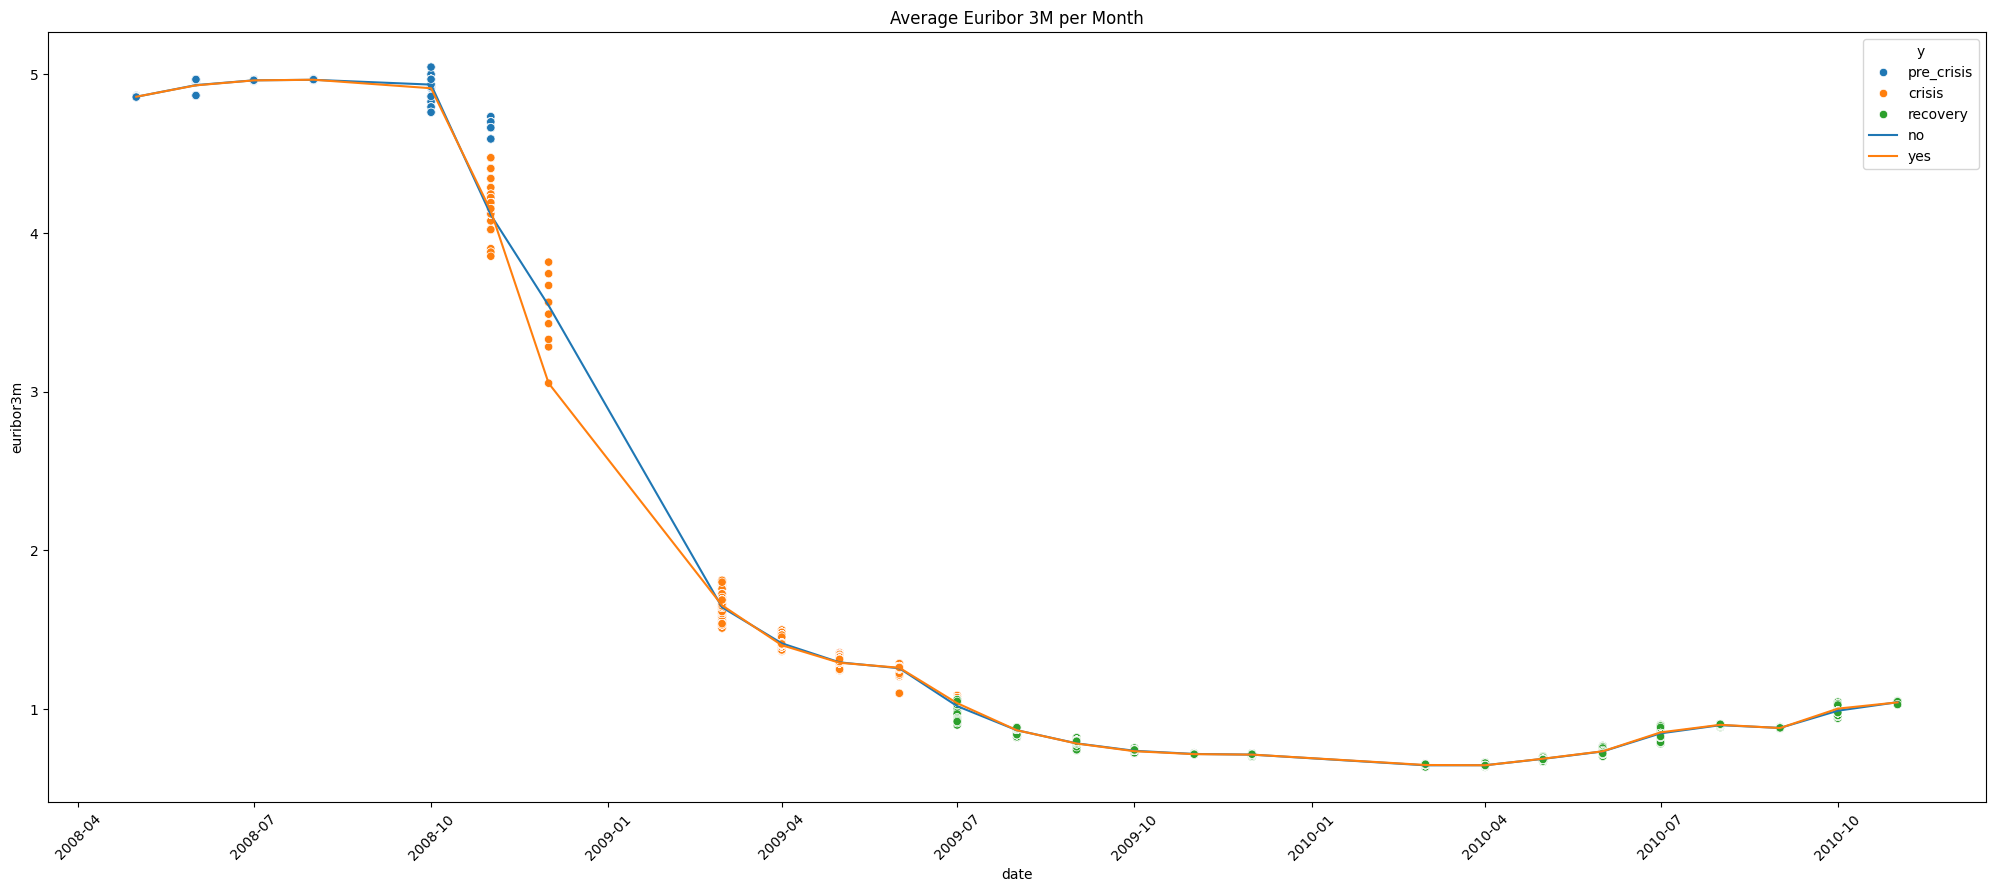

In [ ]:
monthly_avg = (
    df_analysis.groupby(['date','y'])['euribor3m'].mean()
    .reset_index())

plt.figure(figsize=(25,10))

sns.scatterplot(x = 'date' , y = 'euribor3m',hue='phase', data = df_analysis)
sns.lineplot(data=monthly_avg, x='date', y='euribor3m', hue='y')

plt.title("Average Euribor 3M per Month")
plt.xticks(rotation=45)
plt.show()


- The graph shows that in December 2008, Euribor exhibited a relatively wide range of variation.
- The line representing the target variable (y) indicates that some customers subscribed to term deposits when interest rates were lower, which causes the line to slope downward.

##### Employment Variation Rate

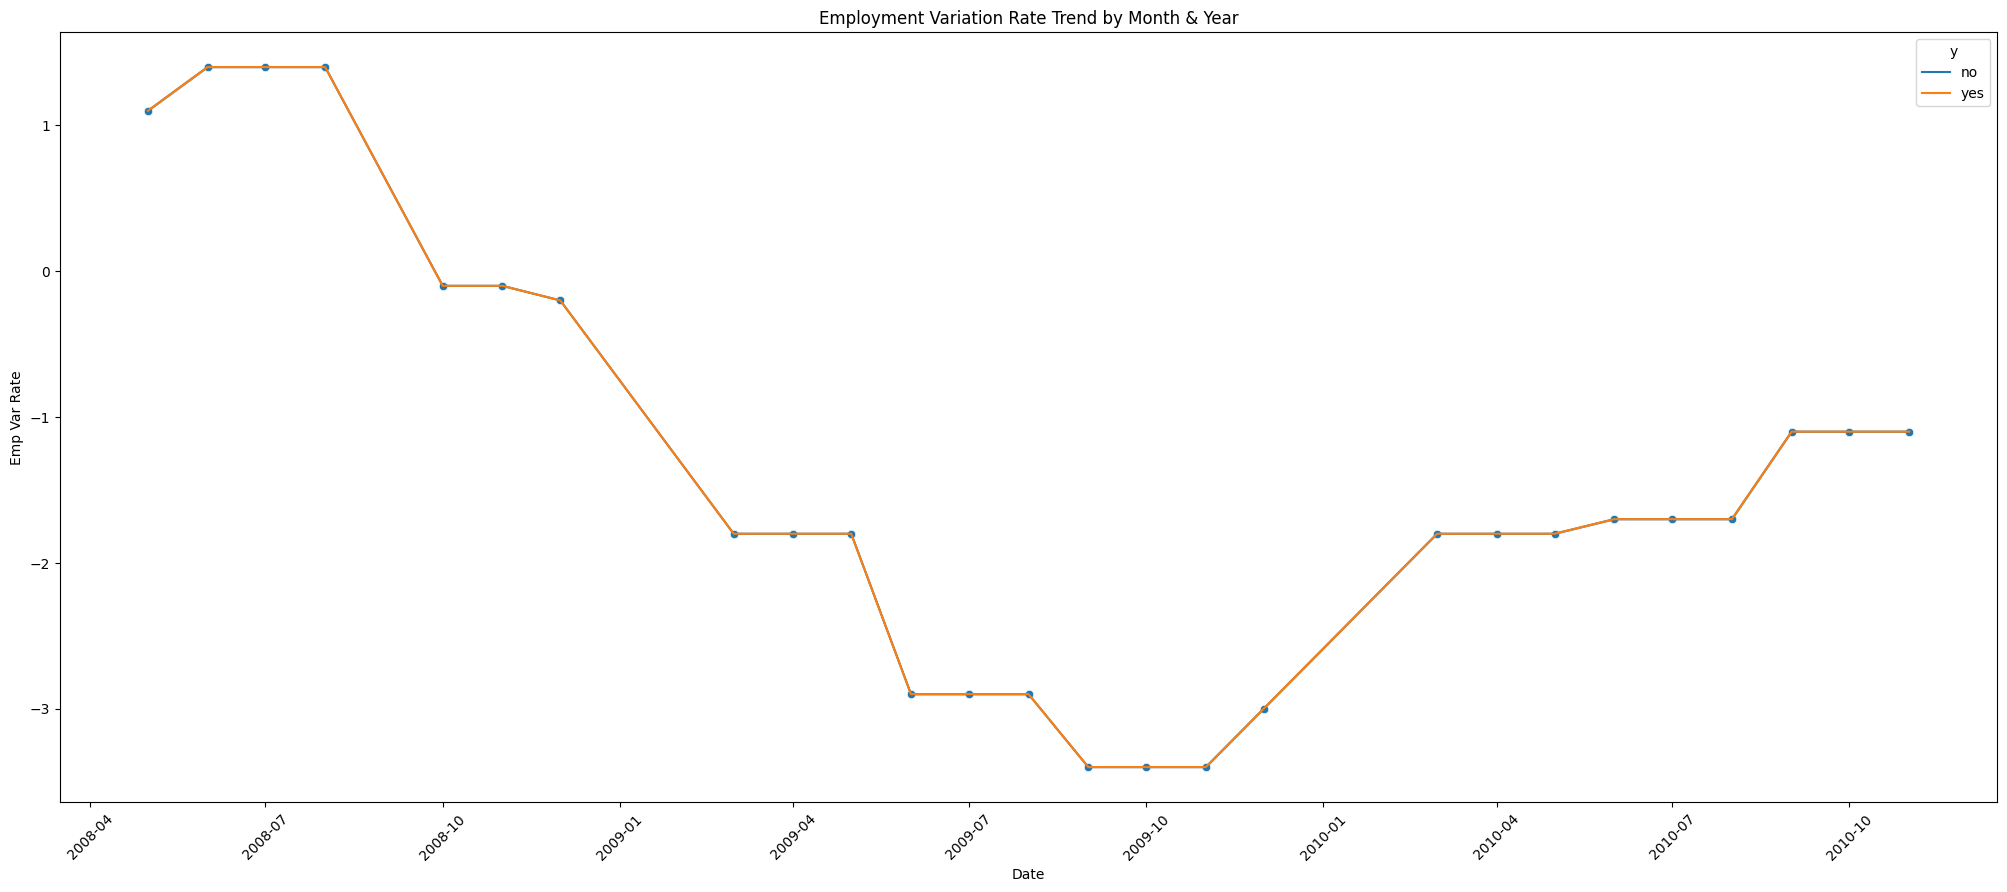

In [ ]:
plt.figure(figsize = (25,10))

sns.scatterplot(x = 'date' , y = 'emp.var.rate', data = df_analysis)
sns.lineplot(x = 'date', y = 'emp.var.rate', data = df_analysis, hue='y')

plt.xticks(rotation=45)

plt.title("Employment Variation Rate Trend by Month & Year")
plt.xlabel("Date")
plt.ylabel("Emp Var Rate")
plt.show()

- The employment variation rate trend moves closely in line with the Euribor interest rate pattern discussed earlier
- During the crisis period, when Euribor declined sharply, the employment variation rate also dropped significantly. This reflects the decadency in labor market conditions, as the crisis led to reduced business activity and rising unemployment across Europe
- As the recovery phase began, although Euribor remained relatively low compared to pre-crisis levels, the employment variation rate gradually improved. This suggests that labor market conditions started to stabilize and employment began to recover, indicating the early stages of economic recovery.

##### Number of Employees

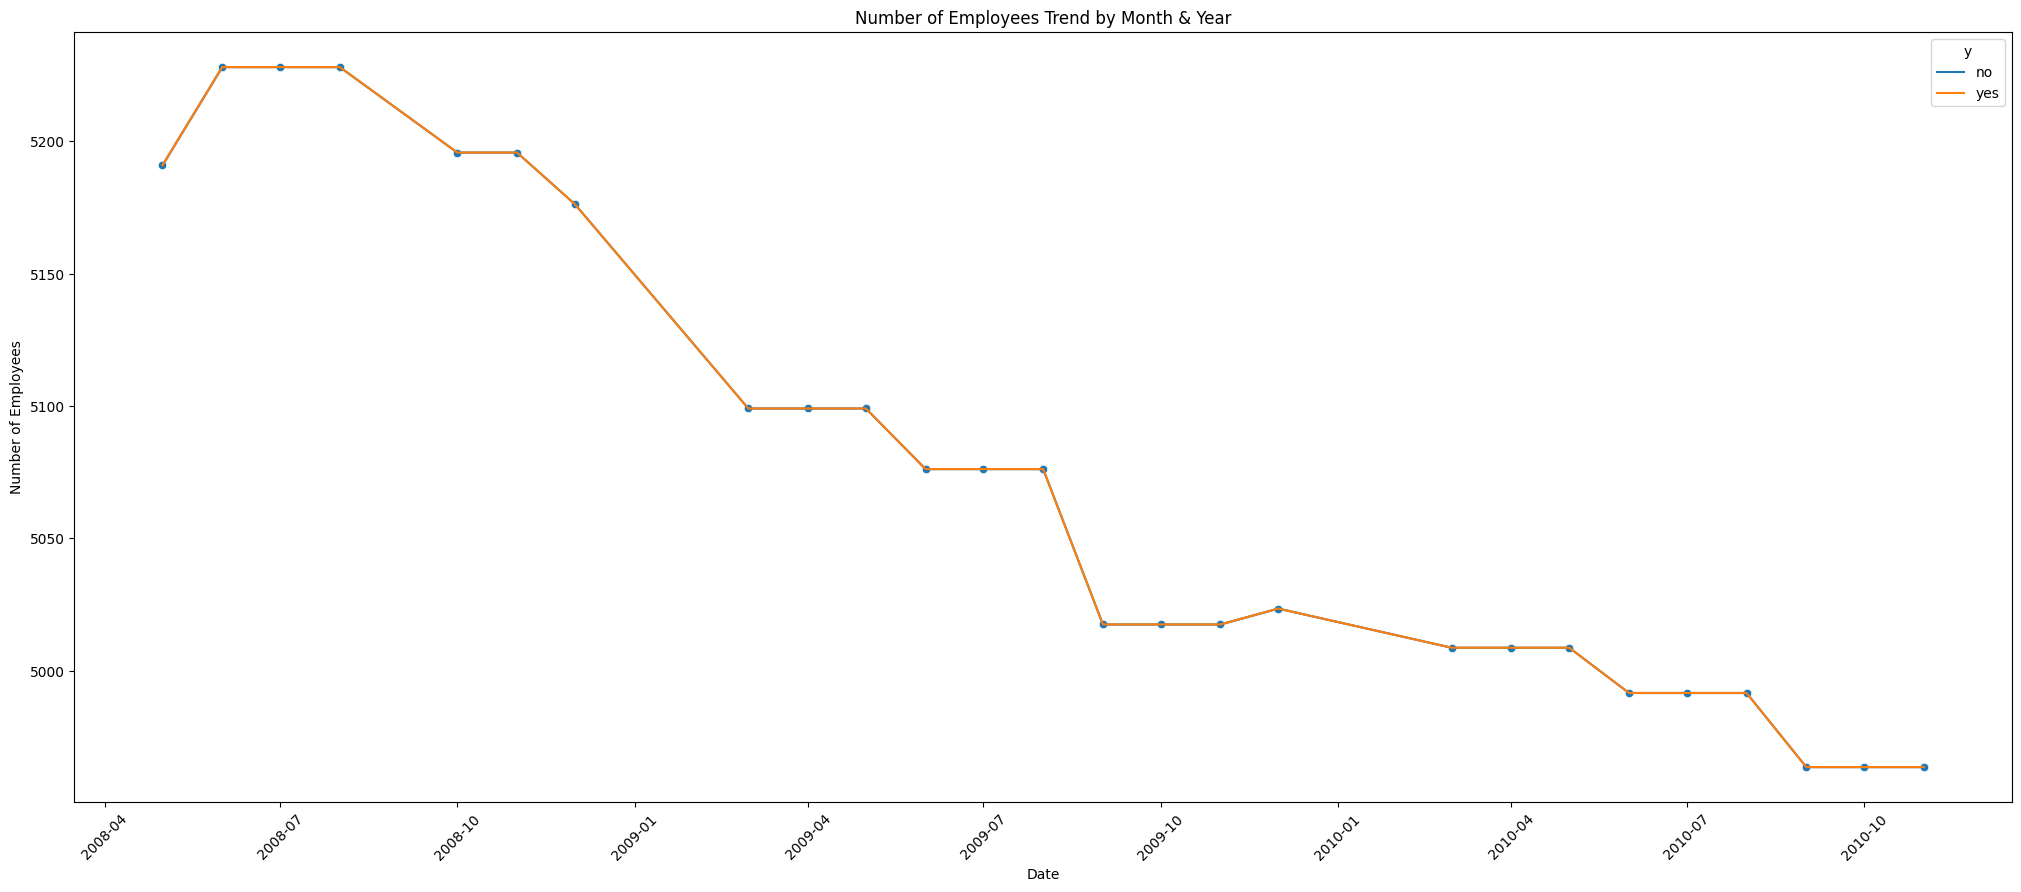

In [ ]:
plt.figure(figsize = (25,10))

sns.scatterplot(x = 'date' , y = 'nr.employed', data = df_analysis)
sns.lineplot(x = 'date', y = 'nr.employed', data = df_analysis, hue='y')

plt.xticks(rotation=45)

plt.title("Number of Employees Trend by Month & Year")
plt.xlabel("Date")
plt.ylabel("Number of Employees")
plt.show()

- The variable nr.employed represents the quarterly average number of employed individuals in Portugal, measured in thousands of persons. This definition is consistent with official employment statistics published for Portugal such as [CEIC](https://www.ceicdata.com/en/portugal/labour-force-survey-employment-by-age-and-sex/employment) surveys.
- The trend in the number of employees is consistent with the patterns observed in both the Euribor rate and the employment variation rate.
- During the pre-crisis period, the number of employees remained relatively stable at a higher level, reflecting stronger economic conditions and higher interest rates.
- As the financial crisis Euribor declined sharply, while the employment variation rate turned significantly negative. This macroeconomic contraction is reflected in the steady decline in the number of employees, indicating layoffs and reduced hiring activity during the downturn.
- Unlike the employment variation rate which begins to improve during the recovery phase the total number of employees continues to decline or recovers more slowly. This is economically reasonable because employment levels are typically a lagging indicator. Even when interest rates remain low and economic conditions start stabilizing, firms tend to be cautious in rehiring until recovery becomes more sustainable.


##### Consumer Price Index

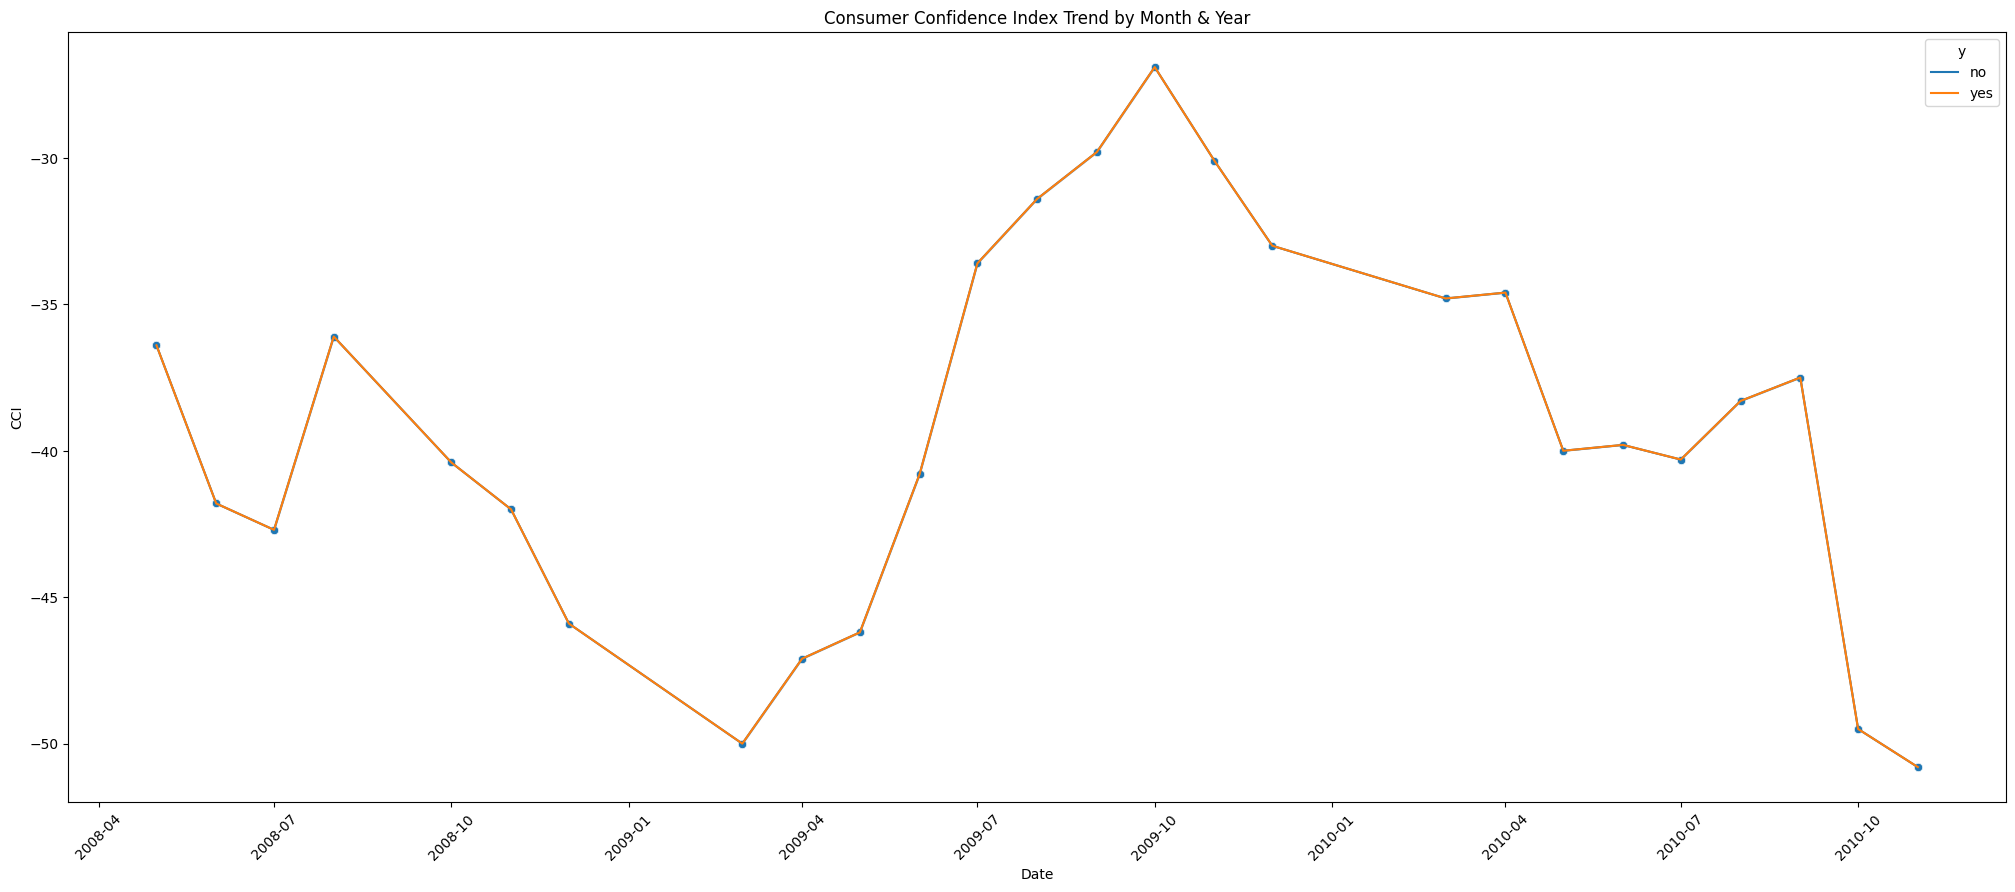

In [ ]:
plt.figure(figsize = (25,10))

sns.scatterplot(x = 'date' , y = 'cons.conf.idx', data = df_analysis)
sns.lineplot(x = 'date', y = 'cons.conf.idx', data = df_analysis, hue='y')

plt.xticks(rotation=45)

plt.title("Consumer Confidence Index Trend by Month & Year")
plt.xlabel("Date")
plt.ylabel("CCI")
plt.show()

- The CCI shows a steady decline through 2008, reaching a low point in early 2009, which align with the broader macroeconomic downturn during the global financial crisis
- There was a rapid rebound in mid-2009, possibly reflecting temporary stabilization in economic expectations
- In 2010, the index becomes more volatile, reflecting an ongoing anxiety (likely tied to the onset of the European debt crisis)
- Overall, the chart suggests that variations in consumer confidence alone may not strongly differentiate subscription outcomes. Campaign success may be more influenced by factors such as outreach intensity or client-specific characteristics

##### Consumer Price Index

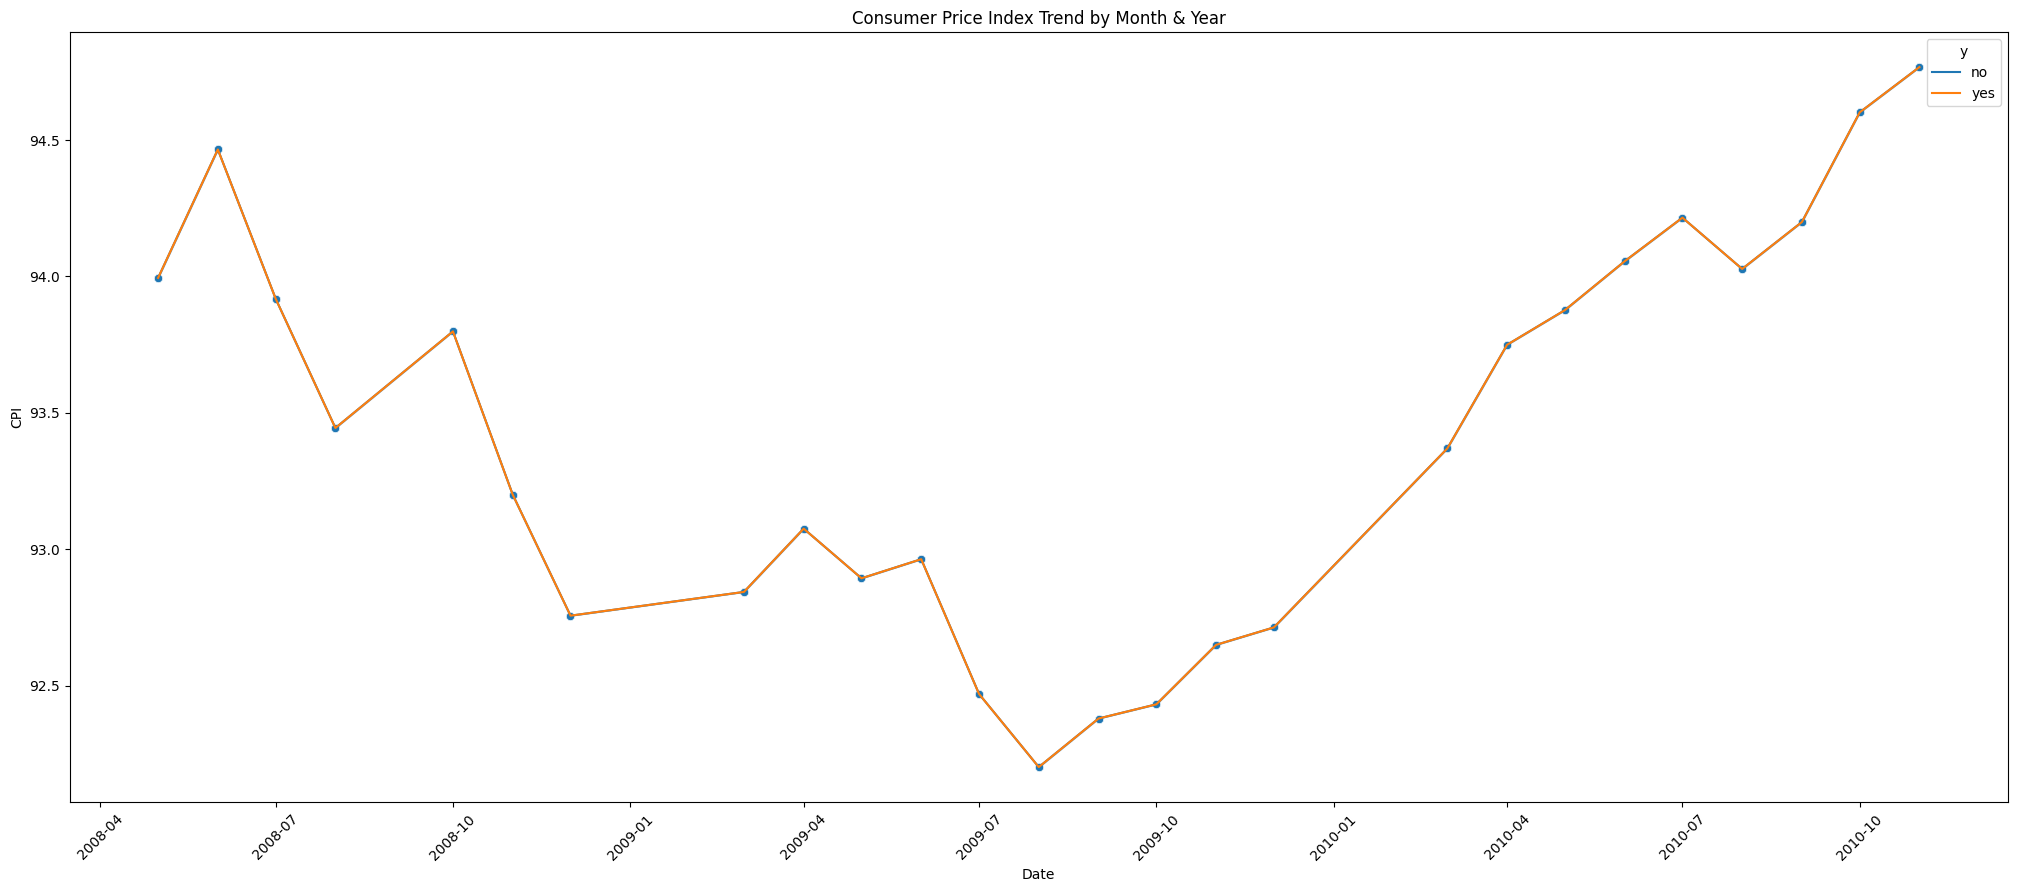

In [ ]:
plt.figure(figsize = (25,10))

sns.scatterplot(x = 'date' , y = 'cons.price.idx', data = df_analysis)
sns.lineplot(x = 'date', y = 'cons.price.idx', data = df_analysis, hue='y')

plt.xticks(rotation=45)

plt.title("Consumer Price Index Trend by Month & Year")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.show()

- The CPI experienced significant fluctuations in 2008

- A major downward trend occured in early 2009, coinciding with the broader economic contraction during the financial crisis

- During late 2009 to 2010 the CPI gradually increased, which may suggest improving economic conditions


##### Correlation Matrix

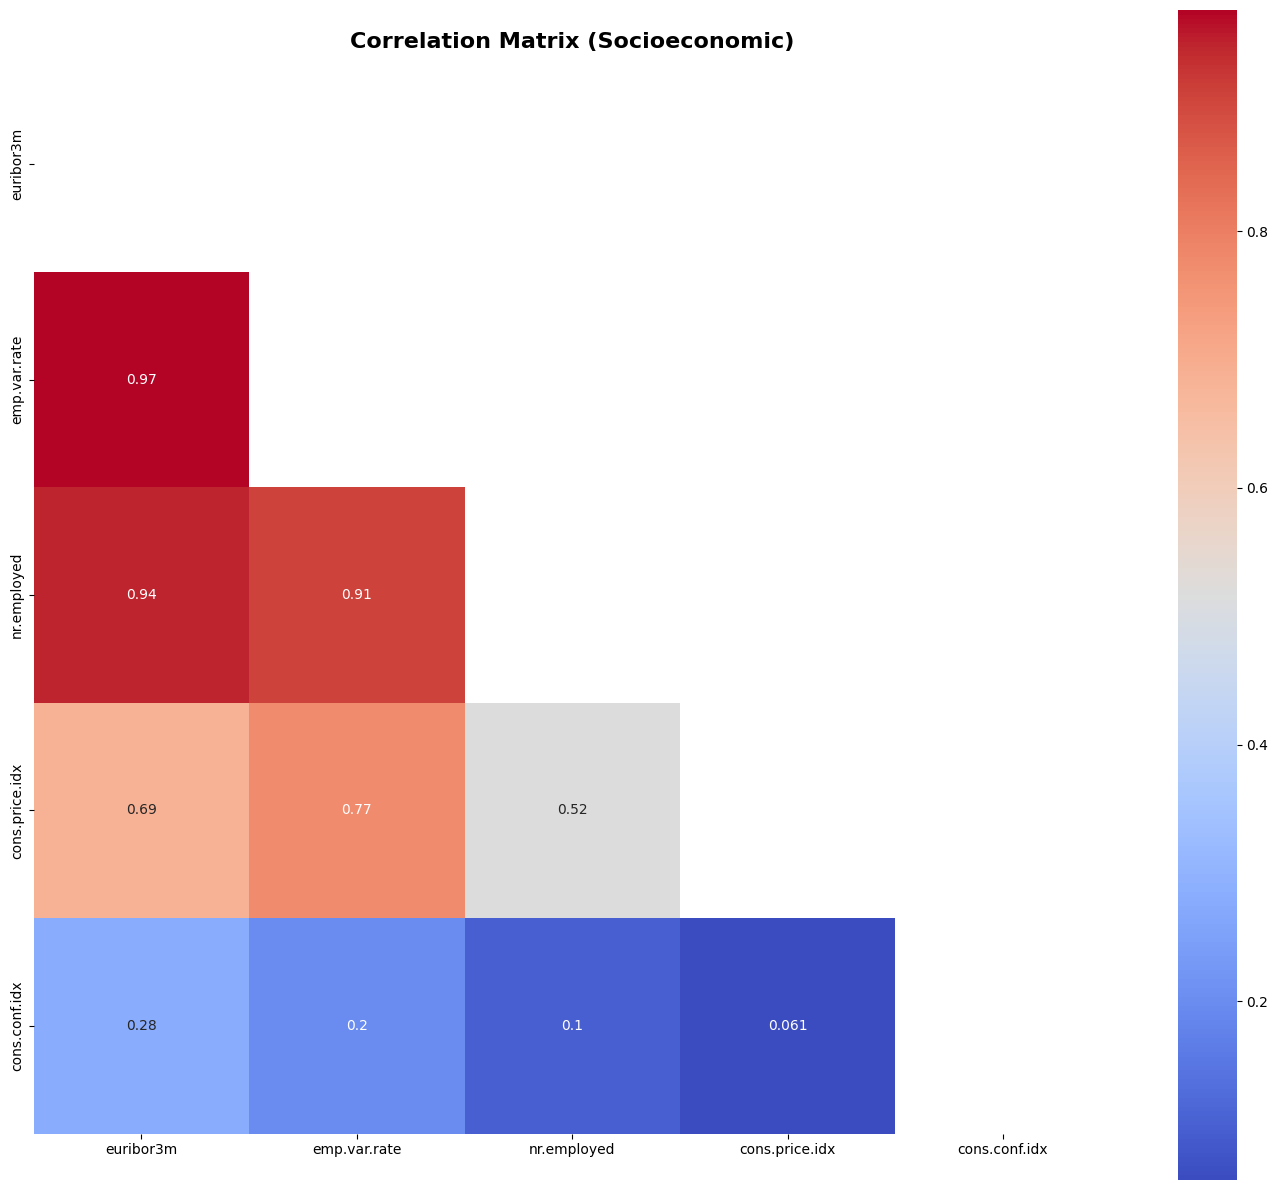

In [ ]:
corr_analysis = df_analysis[['euribor3m','emp.var.rate',
             'nr.employed','cons.price.idx',
             'cons.conf.idx']].corr()
mask = np.triu(np.ones_like(corr_analysis, dtype=bool))

plt.figure(figsize=(14, 12))
sns.heatmap(corr_analysis, annot=True, mask=mask, square=True, cmap='coolwarm')
plt.title('Correlation Matrix (Socioeconomic)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

- The correlation matrix shows strong macroeconomic relationships between :
  -  Euribor and employment - employment variation rate
  -  Euribor - number of employees
  - employment variation rate - number of employees.
- Moderate correlations are found between :
  - CPI - Euribor
  - CPI - employment variation rate.
- Meanwhile, the Consumer Confidence Index (CCI) exhibits weak correlations with all other variables. Additionally, CPI shows a relatively weak relationship with the number of employees.

#### 2.5.2 Deposit Subcription

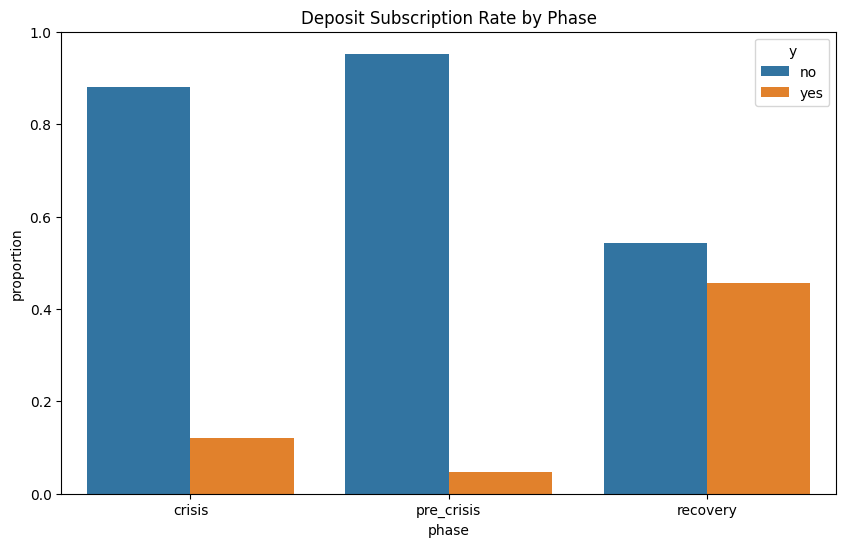

In [ ]:
phase_rate_reset = (
    df_analysis
    .groupby('phase')['y']
    .value_counts(normalize=True)
    .reset_index(name='proportion')
)

plt.figure(figsize=(10,6))

sns.barplot(
    data=phase_rate_reset,
    x='phase',
    y='proportion',
    hue='y'
)

plt.title("Deposit Subscription Rate by Phase")
plt.show()


In percentage terms, the chart shows that during the recovery phase, consumers had the highest subscription rate for term deposits compared to the crisis and pre-crisis phases.

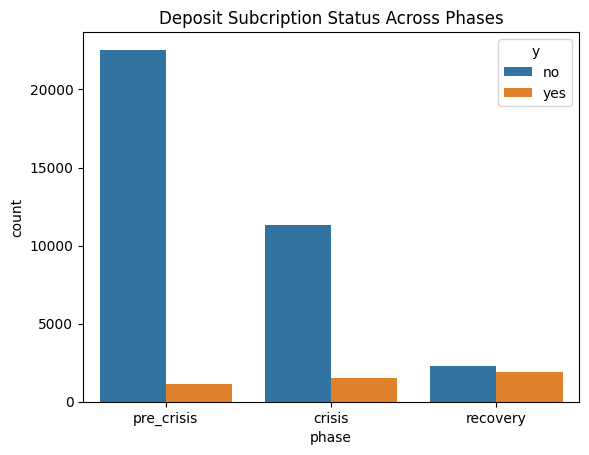

In [ ]:
sns.countplot(
    data=df_analysis,
    x='phase',
    hue='y'
)

plt.title("Deposit Subcription Status Across Phases")
plt.show()

- Telemarketing outreach was significantly higher during the pre-crisis and crisis periods compared to the recovery phase. However, despite the smaller number of contacts made during the recovery phase, the number of customers who subscribed to term deposits was nearly comparable and proportionally even higher than in the earlier phases.
- This suggests that customers during the recovery period may have been more responsive to deposit offers, potentially reflecting improved financial stability or a stronger preference for secure investment instruments such as term deposits.

#### 2.5.3 Age and Job

In [ ]:
df_analysis.groupby('phase')['age'].mean()

phase
crisis        38.795534
pre_crisis    40.113219
recovery      43.209962
Name: age, dtype: float64

During the recovery phase, the average age of customers who subscribed to term deposits was the highest compared to the crisis and pre-crisis periods. This indicates that older customers were relatively more active in subscribing during the recovery phase.

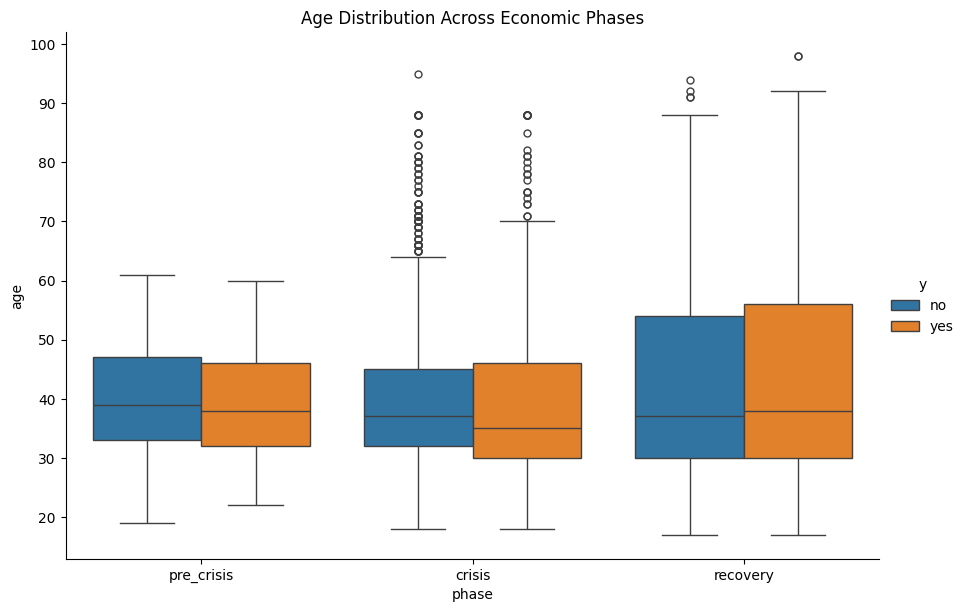

In [ ]:
sns.catplot(
    data=df_analysis,
    x='phase',
    y='age',
    hue='y',
    kind='box',
    height=6,
    aspect=1.5
)

plt.title("Age Distribution Across Economic Phases")
plt.show()


- The recovery phase also shows the widest age distribution
- The boxplot indicates a larger interquartile range and a broader overall range compared to the pre-crisis and crisis periods
- This suggests that during the recovery phase, customers from a more diverse age group participated in term deposit subscriptions

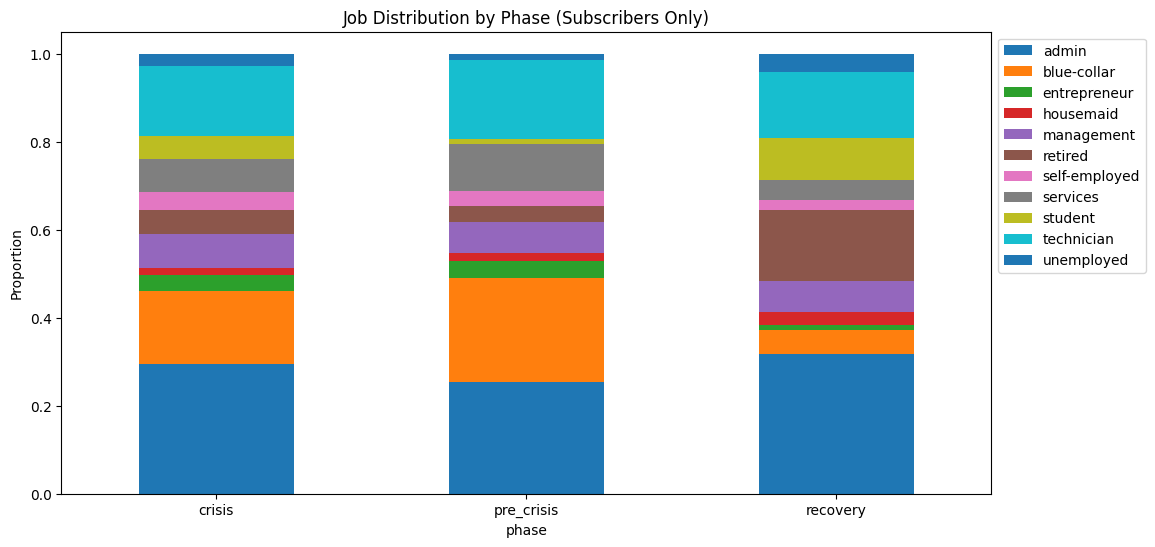

In [ ]:
job_phase_yes = pd.crosstab(
    df_analysis[df_analysis['y'] == 'yes']['phase'],
    df_analysis[df_analysis['y'] == 'yes']['job'],
    normalize='index'
)

job_phase_yes.plot(
    kind='bar',
    stacked=True,
    figsize=(12,6)
)

plt.title("Job Distribution by Phase (Subscribers Only)")
plt.ylabel("Proportion")
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(rotation=0)
plt.show()


## **3. Inferential Statistics**

### **3.1 Categorical Analysis Using Chi-square**

In [ ]:
categorical_features = df[['loan', 'housing', 'day_of_week']].columns

for feature in categorical_features:
    print(f"\n{'='*60}")
    print(f"Feature: {feature}")
    print('='*60)

    # Crosstab
    ct = pd.crosstab(df[feature], df['y'], normalize='index') * 100
    print(f"\nSubscription rate by {feature}:")
    print(ct)

    # Chi-square test
    contingency_table = pd.crosstab(df[feature], df['y'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print(f"\nChi-Square Test:")
    print(f"  Chi-square statistic: {chi2:.2f}")
    print(f"  P-value: {p_value:.6f}")
    print(f"  Degrees of freedom: {dof}")

    if p_value < 0.05:
        print(f"SIGNIFICANT: {feature} is significantly associated with subscription")
    else:
        print(f"NOT SIGNIFICANT: {feature} is not significantly associated")


Feature: loan

Subscription rate by loan:
y            no        yes
loan                      
no    88.687621  11.312379
yes   89.128321  10.871679

Chi-Square Test:
  Chi-square statistic: 0.97
  P-value: 0.324455
  Degrees of freedom: 1
NOT SIGNIFICANT: loan is not significantly associated

Feature: housing

Subscription rate by housing:
y               no        yes
housing                      
no       89.142018  10.857982
yes      88.423518  11.576482

Chi-Square Test:
  Chi-square statistic: 5.04
  P-value: 0.024786
  Degrees of freedom: 1
SIGNIFICANT: housing is significantly associated with subscription

Feature: day_of_week

Subscription rate by day_of_week:
y                   no        yes
day_of_week                      
mon          90.066382   9.933618
tue          88.295483  11.704517
wed          88.354211  11.645789
thu          87.883436  12.116564
fri          89.238132  10.761868

Chi-Square Test:
  Chi-square statistic: 25.81
  P-value: 0.000035
  Degrees of f

### **3.2 Numerical Correlation Analysis**

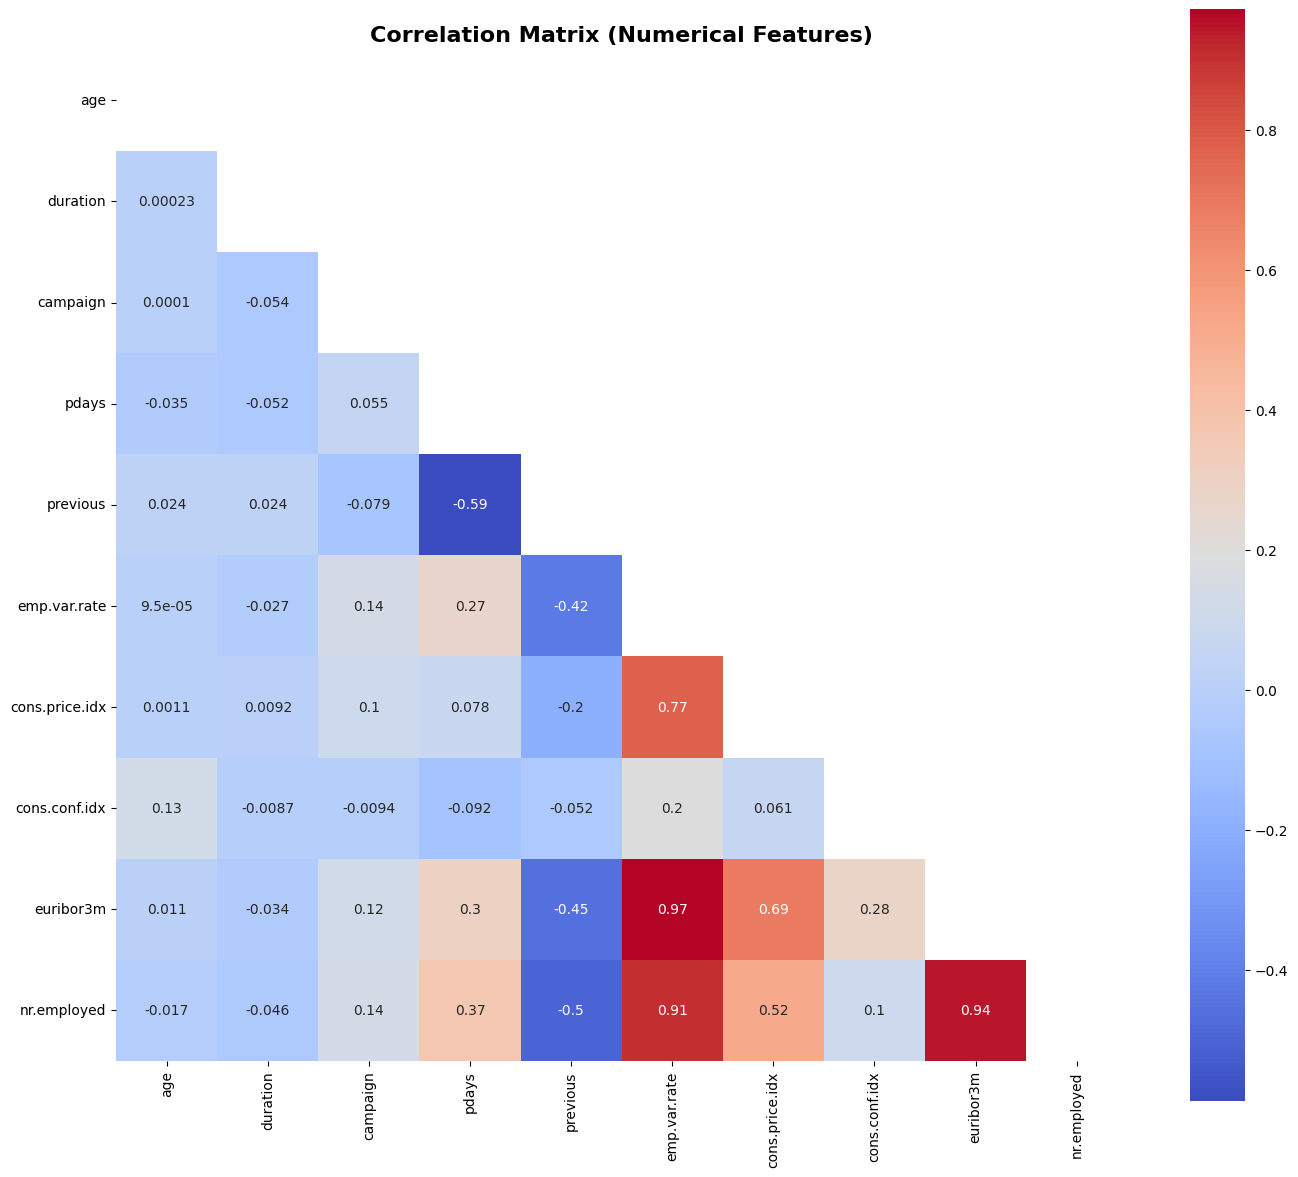

In [ ]:
numerical_features = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
df_corr = df.copy()
corr_matrix = df_corr[numerical_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, mask=mask, square=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Features)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show() #Indexnya diapus

- **Extremely strong correlations**
    - `euribor3m` and `emp.var.rate` (0.97)
    - `nr.employed` and `euribor3m` (0.94)
    - `nr.employed` and `emp.var.rate` (0.91)

- **High positive correlation**: `cons.price.idx` with both `emp.var.rate` (0.77) and `euribor3m` (0.69)

- **Negative correlation**:
    - `pdays` and `previous` (-0.59)
    - `euribor3m`/`emp.var.rate` with `previous` (ranging from -0.42 to -0.5)
    - `campaign` with `age` (0.0001) and `duration` (-0.054)



## **4. Data Prepocessing**

### **4.1 Handling Missing Values, processing columns and Dropping some Socio-economic Features**

In [ ]:
df_processed['job'] = df_processed['job'].replace({'admin.': 'admin'})
df_processed['education'] = df_processed['education'].replace({'university.degree': 'university degree'})
df_processed['education'] = df_processed['education'].replace({'professional.course': 'professional course'})
df_processed['education'] = df_processed['education'].replace({'high.school': 'high school'})
df_processed['education'] = df_processed['education'].replace({'basic.9y': 'basic 9 years'})
df_processed['education'] = df_processed['education'].replace({'basic.4y': 'basic 4 years'})
df_processed['education'] = df_processed['education'].replace({'basic.6y': 'basic 6 years'})

In [ ]:
df_processed.drop_duplicates(inplace=True)
df_processed['is_default_status_known'] = df['default'].apply(lambda x: 'no' if x == 'unknown' else 'yes')
df_processed.dropna(subset=['housing', 'loan'], inplace=True)
df_processed['was_contacted_before'] = df_processed['pdays'].apply(lambda x: 'no' if x == 999 else 'yes')
df_processed.drop(['default','duration','emp.var.rate','cons.price.idx','pdays'], axis=1, inplace=True)

In [ ]:
df_processed.head()

age        job  marital      education housing loan    contact month  \
0   56  housemaid  married  basic 4 years      no   no  telephone   may   
1   57   services  married    high school      no   no  telephone   may   
2   37   services  married    high school     yes   no  telephone   may   
3   40      admin  married  basic 6 years      no   no  telephone   may   
4   56   services  married    high school      no  yes  telephone   may   

  day_of_week  campaign  previous     poutcome  cons.conf.idx  euribor3m  \
0         mon         1         0  nonexistent          -36.4      4.857   
1         mon         1         0  nonexistent          -36.4      4.857   
2         mon         1         0  nonexistent          -36.4      4.857   
3         mon         1         0  nonexistent          -36.4      4.857   
4         mon         1         0  nonexistent          -36.4      4.857   

   nr.employed   y is_default_status_known was_contacted_before  
0       5191.0  no                     yes                   no  
1       5191.0  no                     yes                   no  
2       5191.0  no                     yes                   no  
3       5191.0  no                     yes                   no  
4       5191.0  no                     yes                   no

## **5. Machine Learning**

The models that are utilized in this machine learning includes:

0. Logistic Regression
1. KNN
2. Decision Tree
3. Random Forest
4. Gradient Boosting
5. AdaBoost
6. CatBoost
7. LightGBM
8. XGBoost

### **5.1 Define X (Target) and y (Features)**

In [ ]:
y = df_processed['y'].map({'no': 0, 'yes': 1})
X = df_processed.drop('y', axis=1)

<u> Splitting categorical features and numerical features

In [ ]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()

### **5.2 Train-Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### **5.3 Feature Engineering**

In [ ]:
numerical_pipeline=Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=3))])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')),
    ('imputer', KNNImputer(n_neighbors=3))])

# Combine using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)])

### **5.4 Model Benchmarking (Baseline Approach)**

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0 ),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
}
f2_scorer = make_scorer(fbeta_score, beta=2)
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'f2': f2_scorer,
    'pr_auc': 'average_precision'
    }
results = []

for model_name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    scores = cross_validate(pipe,
                            X_train,
                            y_train,
                            cv=cv_strategy,
                            scoring=scoring,
                            return_train_score=True,
                            n_jobs=-1)
    results.append({
        'model': model_name,
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision'].mean(),
        'recall': scores['test_recall'].mean(),
        'f1': scores['test_f1'].mean(),
        'roc_auc': scores['test_roc_auc'].mean(),
        'f2': scores['test_f2'].mean(),
        'pr_auc': scores['test_pr_auc'].mean(),
        'train_accuracy': scores['train_accuracy'].mean(),
        'train_precision': scores['train_precision'].mean(),
        'train_recall': scores['train_recall'].mean(),
        'train_f1': scores['train_f1'].mean(),
        'train_roc_auc': scores['train_roc_auc'].mean(),
        'train_f2': scores['train_f2'].mean(),
        'train_pr_auc': scores['train_pr_auc'].mean()
    })

In [ ]:
benchmark_df = pd.DataFrame(results)
benchmark_df = benchmark_df.sort_values(by='f2', ascending=False).reset_index(drop=True)
benchmark_df

model  accuracy  precision    recall        f1   roc_auc  \
0        Decision Tree  0.835884   0.296836  0.332321  0.313573  0.619208   
1              XGBoost  0.895203   0.572815  0.279372  0.375326  0.774689   
2        Random Forest  0.890942   0.532020  0.273303  0.361049  0.761977   
3             CatBoost  0.898438   0.613787  0.267786  0.372677  0.789470   
4                  KNN  0.889915   0.523576  0.272199  0.358113  0.714124   
5             LightGBM  0.899278   0.629936  0.260063  0.368002  0.792680   
6    Gradient Boosting  0.900989   0.663739  0.248486  0.361408  0.792649   
7  Logistic Regression  0.899123   0.654854  0.223113  0.332732  0.782093   
8             AdaBoost  0.898905   0.684033  0.193325  0.301197  0.778768   

         f2    pr_auc  train_accuracy  train_precision  train_recall  \
0  0.324558  0.176178        0.995280         0.998922      0.959183   
1  0.311172  0.425309        0.932158         0.897539      0.449876   
2  0.302727  0.399934        0.995233         0.991229      0.966285   
3  0.301742  0.450651        0.928215         0.896880      0.410783   
4  0.301086  0.307232        0.912203         0.713840      0.369830   
5  0.294621  0.457559        0.914668         0.791151      0.330874   
6  0.283965  0.460030        0.905406         0.717478      0.266065   
7  0.256972  0.437124        0.899924         0.665182      0.226903   
8  0.225641  0.412719        0.899379         0.693815      0.193465   

   train_f1  train_roc_auc  train_f2  train_pr_auc  
0  0.978648       0.999887  0.966875      0.998481  
1  0.599329       0.913837  0.499720      0.726695  
2  0.978598       0.999836  0.971173      0.998692  
3  0.563472       0.875225  0.460721      0.674247  
4  0.487203       0.923464  0.409266      0.559554  
5  0.466538       0.882510  0.374421      0.619913  
6  0.388115       0.803716  0.304344      0.503690  
7  0.338357       0.786416  0.261335      0.443365  
8  0.302408       0.783046  0.226030      0.417338

<u> Visualizing benchmark df

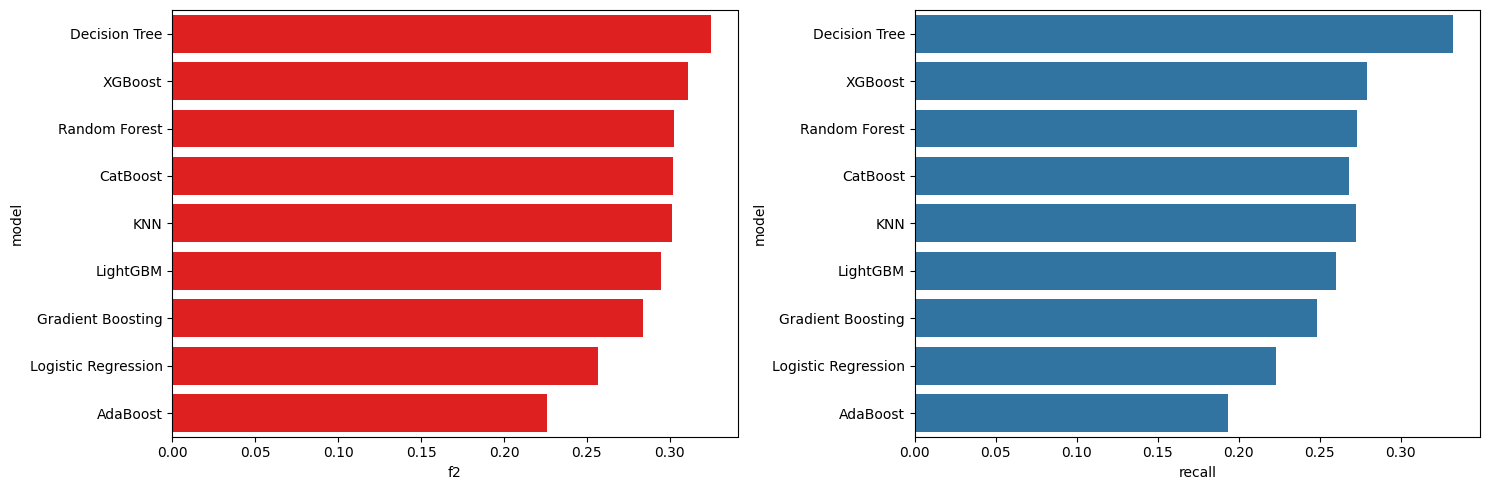

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(data=benchmark_df, y='model', x='f2', ax=ax[0], color='red')
sns.barplot(data=benchmark_df, y='model', x='recall', ax=ax[1])
plt.tight_layout()
plt.show()

### **5.5 Baseline and Balanced Model**

In [ ]:
models_with_class_weight = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Logistic Regression Balanced': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Decision Tree Balanced': DecisionTreeClassifier(random_state=42,class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Random Forest Balanced': RandomForestClassifier(random_state=42, n_estimators=100,class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42, verbose=0 ),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
    'LightGBM Balanced': LGBMClassifier(random_state=42, verbose=-1,class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'XGBoost Balanced': XGBClassifier(random_state=42, eval_metric='logloss',class_weight='balanced')
}

results_balanced = []
for model_name, model in models_with_class_weight.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    scores = cross_validate(pipe,
                            X_train,
                            y_train,
                            cv=cv_strategy,
                            scoring=scoring,
                            return_train_score=True,
                            n_jobs=-1)
    results_balanced.append({
        'model': model_name,
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision'].mean(),
        'recall': scores['test_recall'].mean(),
        'f1': scores['test_f1'].mean(),
        'roc_auc': scores['test_roc_auc'].mean(),
        'f2': scores['test_f2'].mean(),
        'pr_auc': scores['test_pr_auc'].mean(),
        'train_accuracy': scores['train_accuracy'].mean(),
        'train_precision': scores['train_precision'].mean(),
        'train_recall': scores['train_recall'].mean(),
        'train_f1': scores['train_f1'].mean(),
        'train_roc_auc': scores['train_roc_auc'].mean(),
        'train_f2': scores['train_f2'].mean(),
        'train_pr_auc': scores['train_pr_auc'].mean()
    })

In [ ]:
balanced_df = pd.DataFrame(results_balanced)
balanced_df = balanced_df.sort_values(by='f2', ascending=False).reset_index(drop=True)
balanced_df

model  accuracy  precision    recall        f1  \
0              LightGBM Balanced  0.840114   0.373774  0.618314  0.465891   
1   Logistic Regression Balanced  0.819086   0.336108  0.618315  0.435391   
2         Decision Tree Balanced  0.844563   0.319941  0.335628  0.327473   
3                  Decision Tree  0.835884   0.296836  0.332321  0.313573   
4                        XGBoost  0.895203   0.572815  0.279372  0.375326   
5               XGBoost Balanced  0.895203   0.572815  0.279372  0.375326   
6         Random Forest Balanced  0.891968   0.541618  0.274681  0.364396   
7                  Random Forest  0.890942   0.532020  0.273303  0.361049   
8                       CatBoost  0.898438   0.613787  0.267786  0.372677   
9                            KNN  0.889915   0.523576  0.272199  0.358113   
10                      LightGBM  0.899278   0.629936  0.260063  0.368002   
11             Gradient Boosting  0.900989   0.663739  0.248486  0.361408   
12           Logistic Regression  0.899123   0.654854  0.223113  0.332732   
13                      AdaBoost  0.898905   0.684033  0.193325  0.301197   

     roc_auc        f2    pr_auc  train_accuracy  train_precision  \
0   0.787864  0.546755  0.460535        0.857301         0.420537   
1   0.784394  0.529299  0.431727        0.820207         0.338639   
2   0.622863  0.332286  0.184381        0.994696         0.955098   
3   0.619208  0.324558  0.176178        0.995280         0.998922   
4   0.774689  0.311172  0.425309        0.932158         0.897539   
5   0.774689  0.311172  0.425309        0.932158         0.897539   
6   0.762817  0.304677  0.393767        0.994836         0.958165   
7   0.761977  0.302727  0.399934        0.995233         0.991229   
8   0.789470  0.301742  0.450651        0.928215         0.896880   
9   0.714124  0.301086  0.307232        0.912203         0.713840   
10  0.792680  0.294621  0.457559        0.914668         0.791151   
11  0.792649  0.283965  0.460030        0.905406         0.717478   
12  0.782093  0.256972  0.437124        0.899924         0.665182   
13  0.778768  0.225641  0.412719        0.899379         0.693815   

    train_recall  train_f1  train_roc_auc  train_f2  train_pr_auc  
0       0.701255  0.525745       0.892001  0.618633      0.589917  
1       0.622931  0.438723       0.790330  0.533335      0.436513  
2       1.000000  0.977031       0.999887  0.990684      0.998483  
3       0.959183  0.978648       0.999887  0.966875      0.998481  
4       0.449876  0.599329       0.913837  0.499720      0.726695  
5       0.449876  0.599329       0.913837  0.499720      0.726695  
6       0.997794  0.977576       0.999242  0.989606      0.992419  
7       0.966285  0.978598       0.999836  0.971173      0.998692  
8       0.410783  0.563472       0.875225  0.460721      0.674247  
9       0.369830  0.487203       0.923464  0.409266      0.559554  
10      0.330874  0.466538       0.882510  0.374421      0.619913  
11      0.266065  0.388115       0.803716  0.304344      0.503690  
12      0.226903  0.338357       0.786416  0.261335      0.443365  
13      0.193465  0.302408       0.783046  0.226030      0.417338

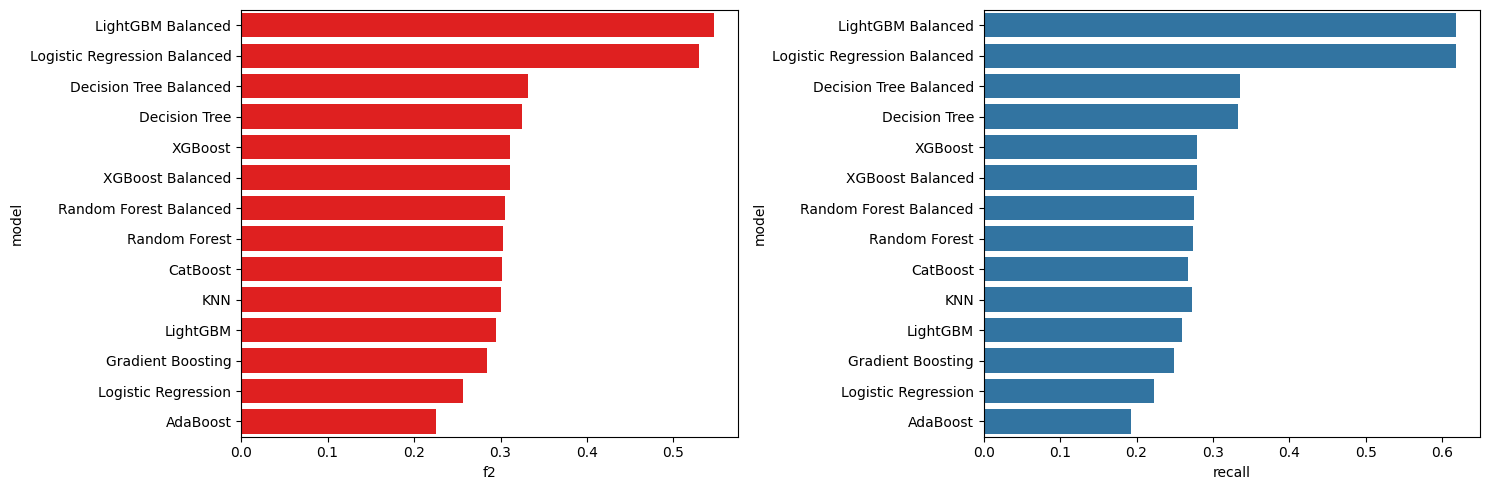

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(data=balanced_df, y='model', x='f2', ax=ax[0], color='red')
sns.barplot(data=balanced_df, y='model', x='recall', ax=ax[1])
plt.tight_layout()
plt.show()

### **5.6 Resampling Method**

In [ ]:
base_model = LGBMClassifier(verbose=-1)

resampling_methods = {
    'No Resampling (Baseline)': None,
    'Random Over-Sampling': RandomOverSampler(random_state=42),
    'Random Under-Sampling': RandomUnderSampler(random_state=42),
    'Near Miss': NearMiss(version=1),
    'SMOTE': SMOTE(random_state=42),
    'SMOTEENN (Hybrid)': SMOTEENN(random_state=42)
}

resampling_resultscv = []

for method_name, sampler in resampling_methods.items():
    print(f"Testing {method_name} with 5-Fold Cross-Validation...")
    if sampler is None:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', base_model)
        ])
    else:
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('sampler', sampler),
            ('classifier', base_model)
        ])

    scores = cross_validate(
        pipeline,
        X_train, y_train,
        cv=cv_strategy,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    resampling_resultscv.append({
        'model': method_name,
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision'].mean(),
        'recall': scores['test_recall'].mean(),
        'f1': scores['test_f1'].mean(),
        'roc_auc': scores['test_roc_auc'].mean(),
        'f2': scores['test_f2'].mean(),
        'pr_auc': scores['test_pr_auc'].mean(),
        'train_accuracy': scores['train_accuracy'].mean(),
        'train_precision': scores['train_precision'].mean(),
        'train_recall': scores['train_recall'].mean(),
        'train_f1': scores['train_f1'].mean(),
        'train_roc_auc': scores['train_roc_auc'].mean(),
        'train_f2': scores['train_f2'].mean(),
        'train_pr_auc': scores['train_pr_auc'].mean()
    })

Testing No Resampling (Baseline) with 5-Fold Cross-Validation...
Testing Random Over-Sampling with 5-Fold Cross-Validation...
Testing Random Under-Sampling with 5-Fold Cross-Validation...
Testing Near Miss with 5-Fold Cross-Validation...
Testing SMOTE with 5-Fold Cross-Validation...
Testing SMOTEENN (Hybrid) with 5-Fold Cross-Validation...


In [ ]:
resampling_df = pd.DataFrame(resampling_resultscv)
resampling_df = resampling_df.sort_values(by='f2', ascending=False).reset_index(drop=True)
resampling_df

model  accuracy  precision    recall        f1  \
0      Random Over-Sampling  0.844780   0.381772  0.606731  0.468568   
1     Random Under-Sampling  0.808013   0.323639  0.640650  0.429736   
2         SMOTEENN (Hybrid)  0.868670   0.436195  0.562051  0.491132   
3                 Near Miss  0.419435   0.139934  0.805850  0.238448   
4                     SMOTE  0.896977   0.578916  0.317982  0.410460   
5  No Resampling (Baseline)  0.899278   0.629936  0.260063  0.368002   

    roc_auc        f2    pr_auc  train_accuracy  train_precision  \
0  0.787433  0.542681  0.462039        0.862806         0.432921   
1  0.783948  0.535337  0.426956        0.826218         0.362898   
2  0.784874  0.531340  0.447659        0.875451         0.459156   
3  0.694123  0.412845  0.323651        0.430695         0.145976   
4  0.784100  0.349474  0.451120        0.909155         0.674696   
5  0.792680  0.294621  0.457559        0.914668         0.791151   

   train_recall  train_f1  train_roc_auc  train_f2  train_pr_auc  
0      0.697739  0.534307       0.891517  0.621671      0.606055  
1      0.712700  0.480709       0.862498  0.597254      0.514501  
2      0.585632  0.514730       0.851779  0.555047      0.496066  
3      0.834252  0.248466       0.715314  0.429336      0.330242  
4      0.375827  0.482719       0.853769  0.412348      0.557947  
5      0.330874  0.466538       0.882510  0.374421      0.619913

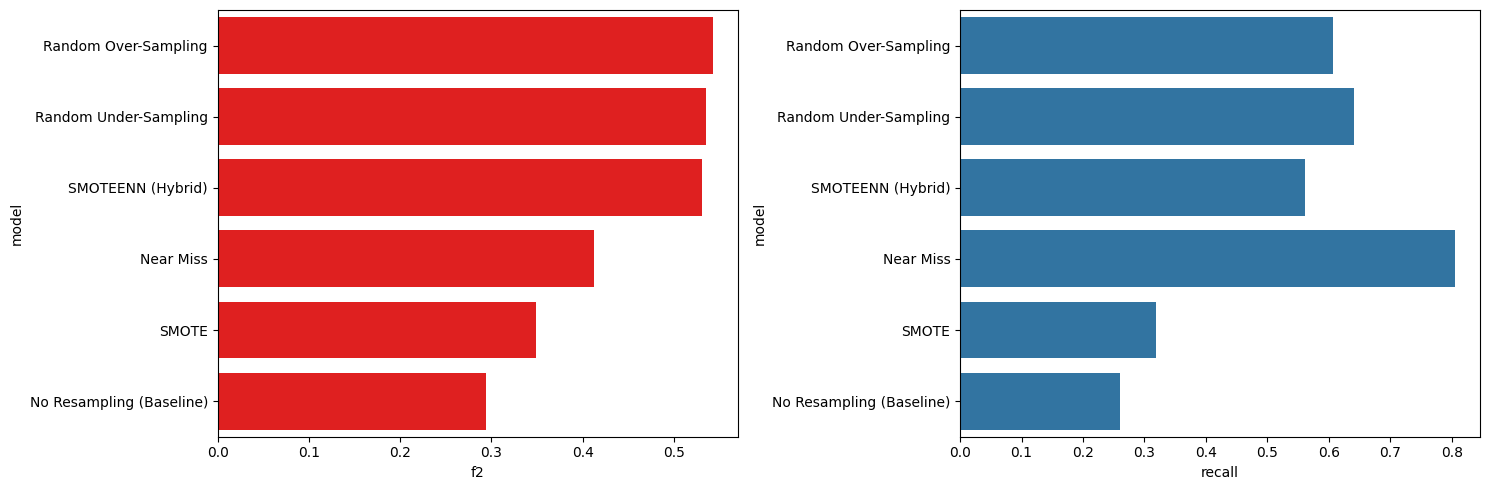

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(data=resampling_df, y='model', x='f2', ax=ax[0], color='red')
sns.barplot(data=resampling_df, y='model', x='recall', ax=ax[1])
plt.tight_layout()
plt.show()

### **5.7 Hyperparameter Tuning**

In [ ]:
lgbm_hyperparam = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.02, 0.03],
    'classifier__class_weight': ['balanced']
}
tuned_results = []

tuning_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', base_model)
])

f2_scorer = make_scorer(fbeta_score, beta=2)
grid_search = GridSearchCV(
    tuning_pipeline,
    lgbm_hyperparam,
    scoring=f2_scorer,
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
f2 = (5 * precision * recall) / (4 * precision + recall) if (precision + recall) > 0 else 0

precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"F2-Score: {f2:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

tuned_results.append({
    'model': 'Tuned Model',
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'roc_auc': roc_auc,
    'f2': f2,
    'pr_auc': pr_auc,
    'train_accuracy': best_model.score(X_train, y_train),
    'train_precision': precision_score(y_train, best_model.predict(X_train)),
    'train_recall': recall_score(y_train, best_model.predict(X_train)),
    'train_f1': f1_score(y_train, best_model.predict(X_train)),
    'train_roc_auc': roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1]),
    'train_f2': (5 * precision * recall) / (4 * precision + recall) if (precision + recall) > 0 else 0,
    'train_pr_auc': auc(recall_curve, precision_curve)
})
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Accuracy: 0.8482
Precision: 0.3956
Recall: 0.6567
F1-Score: 0.4938
F2-Score: 0.5801
ROC-AUC: 0.8188
PR-AUC: 0.4900
Best Hyperparameters: {'classifier__class_weight': 'balanced', 'classifier__learning_rate': 0.02, 'classifier__max_depth': 5, 'classifier__n_estimators': 400}


In [ ]:
tuned_df = pd.DataFrame(tuned_results)
tuned_df = tuned_df.sort_values(by='f2', ascending=False).reset_index(drop=True)
tuned_df

model  accuracy  precision    recall        f1   roc_auc        f2  \
0  Tuned Model  0.848221   0.395612  0.656733  0.493776  0.818837  0.580148   

     pr_auc  train_accuracy  train_precision  train_recall  train_f1  \
0  0.489983        0.840892         0.380286      0.652234  0.480447   

   train_roc_auc  train_f2  train_pr_auc  
0       0.837344  0.580148      0.489983

### **5.8 Model Evaluation**

In [ ]:
df_benchmark = pd.DataFrame(results)
df_balanced = pd.DataFrame(balanced_df)
df_resampled  = pd.DataFrame(resampling_df)
df_tuned     = pd.DataFrame(tuned_results)

df_benchmark['Stage'] = 'Benchmark'
df_resampled['Stage'] = 'Resampling'
df_balanced['Stage']  = 'Balanced'
df_tuned['Stage']     = 'Tuned LightGBM'

df_all = pd.concat([df_benchmark, df_resampled, df_balanced, df_tuned], ignore_index=True)

In [ ]:
best_models = df_all.loc[df_all.groupby("Stage")["f2"].idxmax()]
stage_order = ['Benchmark', 'Resampling', 'Balanced', 'Tuned']
best_models['Stage'] = pd.Categorical(best_models['Stage'], categories=stage_order, ordered=True)
best_models = best_models.sort_values('Stage')
best_models.style.highlight_max(color='green', axis=0)

Why tuned? we prioritize recall, F2-score. Based on the four different model, tunned model has the highest recall + F2-score compared to others while maintaining similar results in every evaluation method

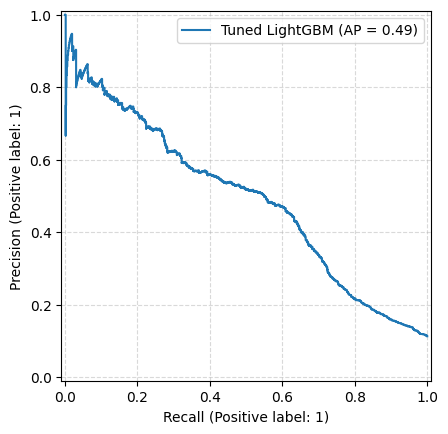

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_estimator(
    best_model,
    X_test,
    y_test,
    name="Tuned LightGBM")
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.48)
plt.show()

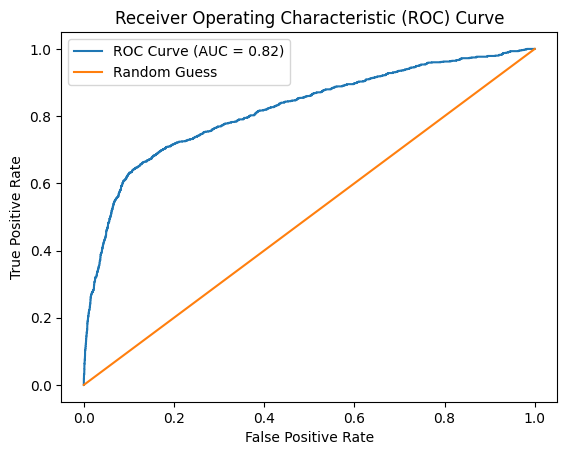

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

ROC-AUC approximately 0.82 meaning the model act as good classifier (>0.8) and also indicate that model is not leaking (0.99 - 1.00)

### **5.9 Cost Benefit Analysis and Shap interpretable Model**

Contact cost

1.	Telecommunication cost: Portugal's telecom market had a sharp divide between landline and mobile costs during this period (2008 – 2013)

-  Landline: EUR 0.02 - 0.03 / min

- Cellular: EUR 0.15 – 0.25 / min

2.	Human Labor costs: Minimum wage in Portugal cost approx. 475 to 500 EUR / month or 0.1 EUR / minutes multiply by 2 for overhead costs that includes office space, management, software licenses, taxes.




Total time calling = 7137 * 219.621 + 903 * 530.502 = 2,046,478.383 seconds / 568 hours / ~24 days

Based on our EDA, the average duration and cost for the telephone using conservative (upper bound) by contact is:

1.	Failed landline approach = 0.852 EUR
2.	Success landline approach = 2.809 EUR
3.	Failed cellular approach = 1.648 EUR
4.	Success cellular approach = 3.874 EUR

If we assume we call everyone using the value count, our current wasted effort

Sample size:

No = 7,137

Yes = 903

Wasted effort = 903 * 3.874 + 7137 * 1.648

`Wasted effort = 15,260 EUR`

Based on reference, on average Portuguese spent 5000 for term deposits, which on average bank gain 1 – 2 (max) % of profit per term deposit placed.

Our conservative initial total profit would be:

Initial Total Profit = total yes * conservative income (50EUR) - total operating cost

Initial Total Profit = 903 * 50 - 1.648 * 7137 - 3.874 * 903

Initial Total Profit = 29,890.000 EUR

Total time calling = 7137 * 219.621 + 903 * 530.502 = 2,046,478.383 seconds / 568 hours / ~24 days


**After ML model (LightGBM Tuned)**

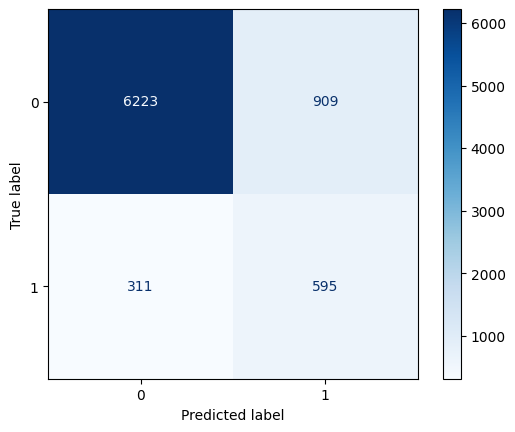

In [ ]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

After ML Profit = 596 * 50 - ( 953 * 1.648 + 596 * 3.874 )

After ML Profit = 25,920.552 (Conservative; assuming we call everyone using cellphone)

Comparing to "call them all scenario". Our initial profit is 29,890. We lost 3969 EUR or 15.3% less profit.

After ML Calling time = 596 * 530.502 + 953 * 219.621 = 525,478 seconds / 145.96 hours / 6.081 days. We reduce operational calling time by `-74.3%` or almost `4 times more efficient`.

If we apply the Efficiency ratio:

$$ \text{Efficiency Ratio} = \frac{\text{Total Profit}}{\text{Time Investment}} $$

or

$$ \text{Ratio}_{\text{ML}} = \frac{0.85 \times \text{Profit}_{\text{Initial}}}{0.25 \times \text{Time}_{\text{Initial}}} = 3.4 \times \text{Ratio}_{\text{Manual}} $$

25,920.552 * (568 / 145.96) = **100,830.947**

100,830.947 / 29,890.000 = 3.373 --> 3.4 times higher profit than initial profit

Hence, if spend the same time calling the potential customer we will potentially gain **340% more profit**

**Shap Interpretable Model**

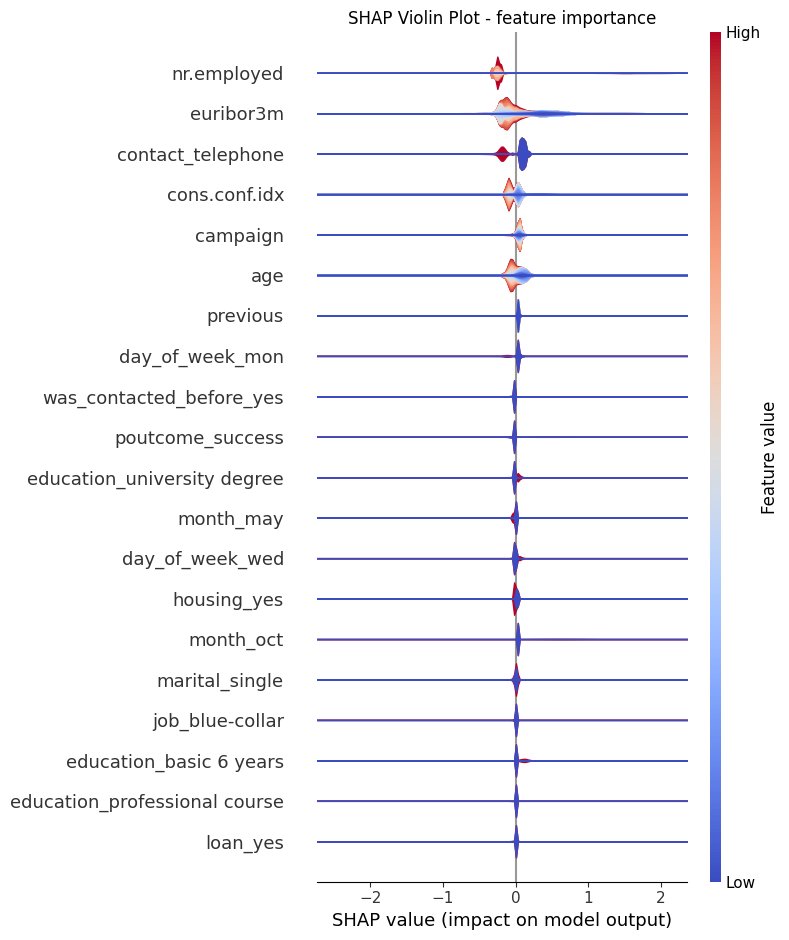

In [ ]:
X_train_preprocessed = best_model.named_steps['preprocessor'].transform(X_train)
explainer = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values = explainer.shap_values(X_train_preprocessed[:1000])  # Use subset for speed

# Get feature names after preprocessing
feature_names_encoded = (
    numerical_features +
    list(best_model.named_steps['preprocessor']
         .named_transformers_['cat']
         .named_steps['encoder']
         .get_feature_names_out(categorical_features))
)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_train_preprocessed[:1000],
                 feature_names=feature_names_encoded, show=False,
                 plot_type="layered_violin", color="coolwarm",)
plt.title('SHAP Violin Plot - feature importance')
plt.tight_layout()
plt.show()

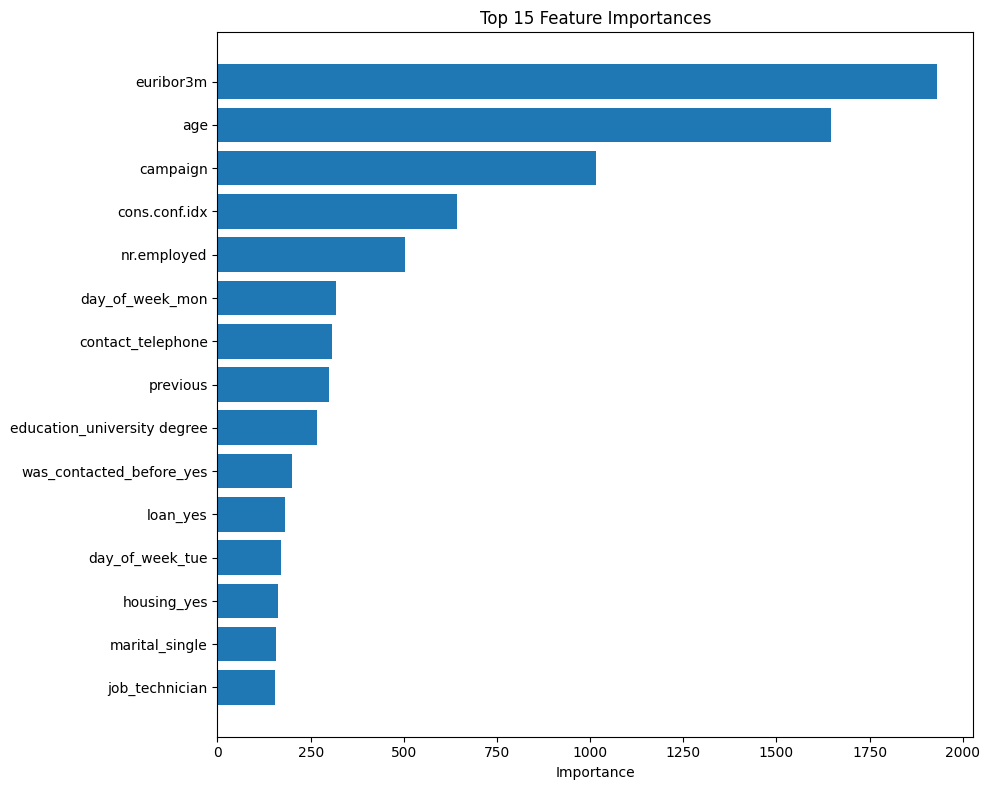

In [ ]:
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_importance = best_model.named_steps['classifier'].feature_importances_


    importance_df = pd.DataFrame({
        'Feature': feature_names_encoded,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False).head(15)

    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Top 15 Feature Importances')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

**SHAP Singular**

In [ ]:
shap.initjs()
def bank_shap_plot(index, pipeline):
    shap.initjs()
    model = pipeline.named_steps['classifier']
    preprocessor = pipeline.named_steps['preprocessor']

    # Transform and turn into a labeled DataFrame
    X_transformed = preprocessor.transform(X_test)
    if hasattr(X_transformed, "toarray"):
        X_transformed = X_transformed.toarray()

    X_df = pd.DataFrame(X_transformed, columns=feature_names_encoded)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_df)
    if isinstance(shap_values, list):
        sv = shap_values[1][index]
        ev = explainer.expected_value[1]
    else:
        # If it's a single array, use it directly
        sv = shap_values[index]
        ev = explainer.expected_value

    return shap.force_plot(ev, sv, X_df.iloc[index, :])

In [ ]:
shap.initjs()
bank_shap_plot(0, best_model)

- Base Value (-0.5246): This is the "starting line." It represents the average prediction (in log-odds) for all customers in your dataset.
- f(x) = -1.23: This is the model's actual final score for this specific customer. Since $-1.23$ is lower than the base value, the model thinks this customer is less likely to subscribe than the average person.
- Higher $\leftrightarrow$ Lower: * Red arrows (Pushing Right): Features that increase the prediction score.Blue arrows (Pushing Left): Features that decrease the prediction score.

In [ ]:
shap.initjs()
bank_shap_plot(521, best_model)

- Base Value (-0.5246): This is the average prediction across the entire dataset. It represents the "starting point" if the model knew nothing about this specific customer.
- In Observation 521, $f(x) = 0.02$. This value is higher than the base, indicating a much higher likelihood of subscription compared to the average

## **6.  Conclusion and Recommendation**

**Conclusion**

1. **Data Key Findings**:

    - Customers who have these characteristics are likely to describe term deposits:

      1. Age - Late 20s to early 30s

      2. Marital status - Single

      3. Job - Student, Retired

      4. Education - University degree

    - `duration`, `euribor3m`, and `emp.var.rate`, `cons.price.idx` and `nr.employed` have high discriminative power, which means these features can distinguish subscribers from non-subscribers

    - It shows that the customer would more likely to subscribe when they are contacted recently, and specifically in the month of March and December

    - The shorter duration of calls result in a higher chance of deposit subscription

    - Majority of customers who have subscribed deposit previously have a higher chance to subscribe again in the next campaign

    - Subcriptions to deposit appear more frequent when economic indicators `employment variation rate` are lower and `number employment` higher, and the major proportion of success deposits occurs when the interest rate (`euribor3m`) is higher

2. **Model Performance**:
   - Achieved Recall: 0.653 (Target: ≥0.60)
   - Achieved F2-Score: 0.573 (Target: ≥0.55)
   - Achieved PR-AUC: 0.481 (Target: ≥0.50)

3. **Model Key Findings**:
   - Successfully built a predictive model for roughly **65%** term deposit subscriptions
   - Addressed class imbalance through resampling and class weighting
   - Identified most influential features for subscription prediction
   - Model provides actionable insights for marketing optimization

4. **Business Impact**:
   - The ML profit generates 3.4 times higher than initial profit or `340% more profit` gain compared to baseline approach
   - Enables targeted marketing campaigns with higher efficiency
   - Reduces unnecessary customer contacts improving satisfaction
   - Provides data-driven prioritization for call center operations

**Recommendation**

1. **Recommendations for Data**:
    - Feature enrichment: Add more informative features such as location-based features

    - Behavioral data: Integrate transaction history or average monthly balances to better predict the liquidity of a customer before outreach

2. **Recommendations for Business (Marketing Team)**:

    - Dynamic targeting strategy:
      1. Prioritize outreach to high-probability customers identified by the model, especially during periods of low euribor rates or consumer confidence, where traditional mass marketing is least efficient

      2. Instead of calling all customers (baseline), the bank should only contact those flagged by the model. This allows the bank to achieve higher conversion rates with significantly fewer calls, reducing operational costs while simultaneously increasing revenue

      3. Create "Gold," "Silver," and "Bronze" lead tiers based on model probability, assigning the most experienced sales agents to the "Gold" tier to further boost conversion rates

    - Economic phase adaptation: Develop specific scripts for different economic phases; for instance, emphasizing safety and stability during periods of low consumer confidence

    - In the case where the budget is constrained (for example the funding only able to reach out 1,000 customers), the marketing team can rank the top 1,000 high-scoring customers by looking at the highest subscription prediction and the feature importances as well. If customers have the same overall prediction percentage, then the customer who has the highest portion of the top feature importances will be ranked higher.

3. **Recommendations for model**:

    - Periodic re-training: Retrain the model every 3-6 months to account for shifting consumer behavior as macroeconomic indicators fluctuate

   - Threshold tuning: Continuously adjust the classification threshold to maintain the optimal balance between Recall and F2-Score, ensuring the cost-benefit ratio remains favorable for the bank